In [1]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080 Ti'

In [19]:
# clean torch memory
torch.cuda.empty_cache()

### Fine-tuning YOLONAS on custom dataset

In [8]:
from super_gradients.training import Trainer

YOLO_NAS_CHECKPOINT_DIR = '/home/etaylor/code_projects/thesis/checkpoints/yolo_nas'
trainer = Trainer(experiment_name='yolo_nas', ckpt_root_dir=YOLO_NAS_CHECKPOINT_DIR)

In [9]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [10]:
dataset_params = {
    'train_images_dir':'/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/annotations/yolo_split/images',
    'train_labels_dir':'/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/annotations/yolo_split/labels',
    'val_images_dir':'/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/annotations/yolo_split/images',
    'val_labels_dir':'/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/annotations/yolo_split/labels',
    'classes': ['clear', 'cloudy', 'amber']
}

In [21]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/annotations/yolo_split",
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_test_26-04-2024_15-44-44/annotations/yolo_split",
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 106/106 [00:00<00:00, 1505.39it/s]


In [22]:
train_data.dataset.transforms

/home/etaylor/.conda/envs/yolo_nas/lib/python3.10/site-packages/super_gradients/training/utils/visualization/utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("gist_rainbow", num_classes)


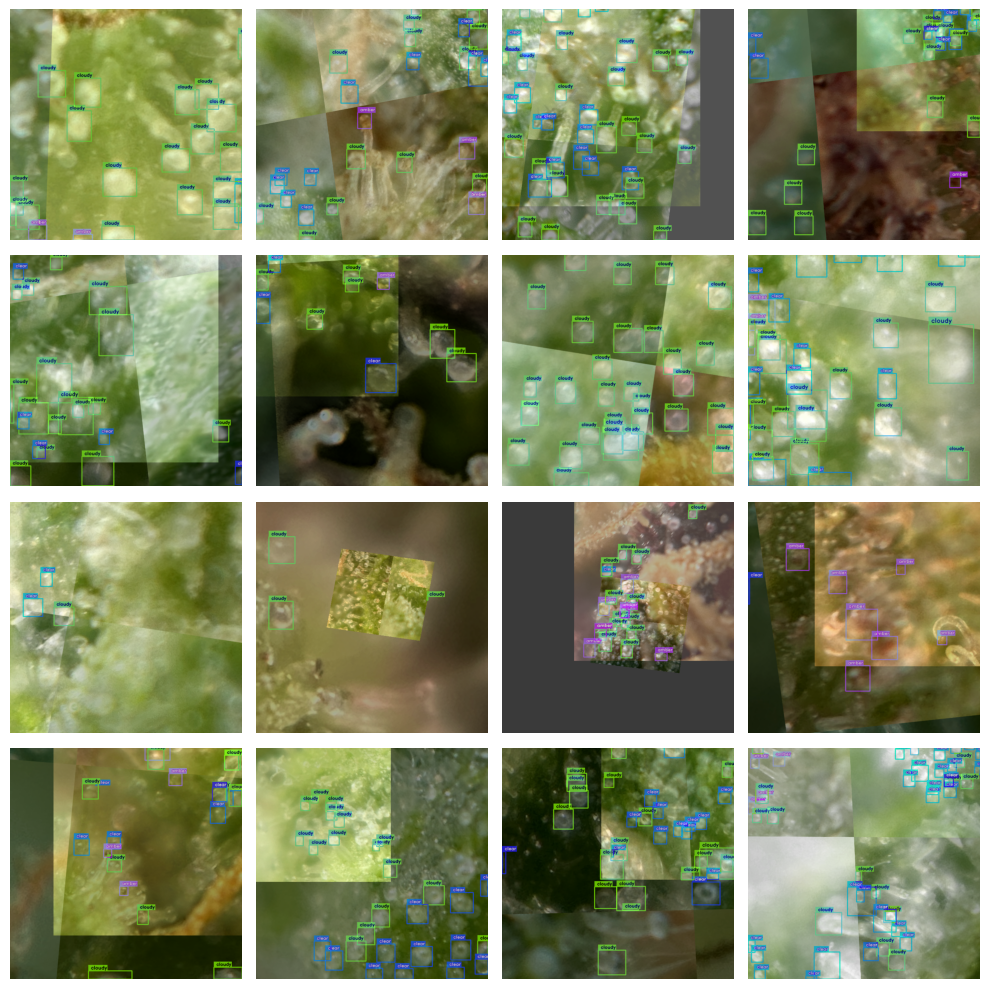

In [23]:
train_data.dataset.plot()

In [24]:
from super_gradients.training import models
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2024-05-25 22:00:47] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-05-25 22:00:47] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


[2024-05-25 22:00:47] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


In [25]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 100,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'precision@0.50'
}

/home/etaylor/.conda/envs/yolo_nas/lib/python3.10/site-packages/super_gradients/training/losses/ppyolo_loss.py:669: DeprecationWarning: A reg_max argument is not needed for PPYoloE loss anymore. It is deprecated since SG 3.6.0 and will be removed in the SG 3.8.0.You can safely omit this argument as it is not used anymore and we infer it automatically from model's outputs
  warnings.warn(


In [26]:
trainer.train(model=model,
            training_params=train_params,
            train_loader=train_data,
            valid_loader=val_data)

[2024-05-25 22:00:53] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240525_220053_364673`
[2024-05-25 22:00:53] INFO - sg_trainer.py - Checkpoints directory: /home/etaylor/code_projects/thesis/checkpoints/yolo_nas/yolo_nas/RUN_20240525_220053_364673
[2024-05-25 22:00:53] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to /home/etaylor/code_projects/thesis/checkpoints/yolo_nas/yolo_nas/RUN_20240525_220053_364673/console_May25_22_00_53.txt


/home/etaylor/.conda/envs/yolo_nas/lib/python3.10/site-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/home/etaylor/.conda/envs/yolo_nas/lib/python3.10/site-packages/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
[2024-05-25 22:00:55] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 av

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.3523
│   ├── Ppyoloeloss/loss_iou = 0.7588
│   ├── Ppyoloeloss/loss_dfl = 0.6211
│   └── Ppyoloeloss/loss = 3.7321
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.4477
    ├── Ppyoloeloss/loss_iou = 0.6434
    ├── Ppyoloeloss/loss_dfl = 0.5972
    ├── Ppyoloeloss/loss = 3.6882
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0
    ├── F1@0.50 = 0.0
    └── Best_score_threshold = 0.05



Validating epoch 1: 100%|██████████| 14/14 [00:03<00:00,  4.08it/s]
[2024-05-25 22:02:21] INFO - base_sg_logger.py - Checkpoint saved in /home/etaylor/code_projects/thesis/checkpoints/yolo_nas/yolo_nas/RUN_20240525_220053_364673/ckpt_best.pth
[2024-05-25 22:02:21] INFO - sg_trainer.py - Best checkpoint overriden: validation Precision@0.50: 0.03604505956172943


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2019
│   │   ├── Epoch N-1      = 2.3523 (↘ -1.1504)
│   │   └── Best until now = 2.3523 (↘ -1.1504)
│   ├── Ppyoloeloss/loss_iou = 0.5558
│   │   ├── Epoch N-1      = 0.7588 (↘ -0.2029)
│   │   └── Best until now = 0.7588 (↘ -0.2029)
│   ├── Ppyoloeloss/loss_dfl = 0.4464
│   │   ├── Epoch N-1      = 0.6211 (↘ -0.1746)
│   │   └── Best until now = 0.6211 (↘ -0.1746)
│   └── Ppyoloeloss/loss = 2.2042
│       ├── Epoch N-1      = 3.7321 (↘ -1.5279)
│       └── Best until now = 3.7321 (↘ -1.5279)
└── Validation
    ├── Ppyoloeloss/loss_cls = 17.7215
    │   ├── Epoch N-1      = 2.4477 (↗ 15.2738)
    │   └── Best until now = 2.4477 (↗ 15.2738)
    ├── Ppyoloeloss/loss_iou = 0.4119
    │   ├── Epoch N-1      = 0.6434 (↘ -0.2315)
    │   └── Best until now = 0.6434 (↘ -0.2315)
    ├── Ppyoloeloss/loss_dfl = 0.4074
    │   ├── Epoch N-1      = 0.5972 (↘ -0.1898)
    │   └── Best until now = 0.5972 (↘ -0.1898)
    ├── Ppyoloeloss/l

Validating epoch 2: 100%|██████████| 14/14 [00:03<00:00,  4.15it/s]
[2024-05-25 22:03:06] INFO - base_sg_logger.py - Checkpoint saved in /home/etaylor/code_projects/thesis/checkpoints/yolo_nas/yolo_nas/RUN_20240525_220053_364673/ckpt_best.pth
[2024-05-25 22:03:06] INFO - sg_trainer.py - Best checkpoint overriden: validation Precision@0.50: 0.05285342037677765


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0546
│   │   ├── Epoch N-1      = 1.2019 (↘ -0.1474)
│   │   └── Best until now = 1.2019 (↘ -0.1474)
│   ├── Ppyoloeloss/loss_iou = 0.4773
│   │   ├── Epoch N-1      = 0.5558 (↘ -0.0786)
│   │   └── Best until now = 0.5558 (↘ -0.0786)
│   ├── Ppyoloeloss/loss_dfl = 0.4098
│   │   ├── Epoch N-1      = 0.4464 (↘ -0.0366)
│   │   └── Best until now = 0.4464 (↘ -0.0366)
│   └── Ppyoloeloss/loss = 1.9416
│       ├── Epoch N-1      = 2.2042 (↘ -0.2626)
│       └── Best until now = 2.2042 (↘ -0.2626)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3945
    │   ├── Epoch N-1      = 17.7215 (↘ -16.327)
    │   └── Best until now = 2.4477 (↘ -1.0532)
    ├── Ppyoloeloss/loss_iou = 0.3815
    │   ├── Epoch N-1      = 0.4119 (↘ -0.0304)
    │   └── Best until now = 0.4119 (↘ -0.0304)
    ├── Ppyoloeloss/loss_dfl = 0.3851
    │   ├── Epoch N-1      = 0.4074 (↘ -0.0223)
    │   └── Best until now = 0.4074 (↘ -0.0223)
    ├── Ppyoloeloss/l

Validating epoch 3: 100%|██████████| 14/14 [00:03<00:00,  4.12it/s]
[2024-05-25 22:03:56] INFO - base_sg_logger.py - Checkpoint saved in /home/etaylor/code_projects/thesis/checkpoints/yolo_nas/yolo_nas/RUN_20240525_220053_364673/ckpt_best.pth
[2024-05-25 22:03:56] INFO - sg_trainer.py - Best checkpoint overriden: validation Precision@0.50: 0.06367433071136475


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.06
│   │   ├── Epoch N-1      = 1.0546 (↗ 0.0055)
│   │   └── Best until now = 1.0546 (↗ 0.0055)
│   ├── Ppyoloeloss/loss_iou = 0.4764
│   │   ├── Epoch N-1      = 0.4773 (↘ -0.0008)
│   │   └── Best until now = 0.4773 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.4172
│   │   ├── Epoch N-1      = 0.4098 (↗ 0.0074)
│   │   └── Best until now = 0.4098 (↗ 0.0074)
│   └── Ppyoloeloss/loss = 1.9537
│       ├── Epoch N-1      = 1.9416 (↗ 0.012)
│       └── Best until now = 1.9416 (↗ 0.012)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1235
    │   ├── Epoch N-1      = 1.3945 (↘ -0.271)
    │   └── Best until now = 1.3945 (↘ -0.271)
    ├── Ppyoloeloss/loss_iou = 0.3756
    │   ├── Epoch N-1      = 0.3815 (↘ -0.0059)
    │   └── Best until now = 0.3815 (↘ -0.0059)
    ├── Ppyoloeloss/loss_dfl = 0.3867
    │   ├── Epoch N-1      = 0.3851 (↗ 0.0016)
    │   └── Best until now = 0.3851 (↗ 0.0016)
    ├── Ppyoloeloss/loss = 1.8858
  

Validating epoch 4: 100%|██████████| 14/14 [00:03<00:00,  4.13it/s]
[2024-05-25 22:04:53] INFO - base_sg_logger.py - Checkpoint saved in /home/etaylor/code_projects/thesis/checkpoints/yolo_nas/yolo_nas/RUN_20240525_220053_364673/ckpt_best.pth
[2024-05-25 22:04:53] INFO - sg_trainer.py - Best checkpoint overriden: validation Precision@0.50: 0.08191005885601044


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0419
│   │   ├── Epoch N-1      = 1.06   (↘ -0.0181)
│   │   └── Best until now = 1.0546 (↘ -0.0126)
│   ├── Ppyoloeloss/loss_iou = 0.4613
│   │   ├── Epoch N-1      = 0.4764 (↘ -0.0152)
│   │   └── Best until now = 0.4764 (↘ -0.0152)
│   ├── Ppyoloeloss/loss_dfl = 0.4184
│   │   ├── Epoch N-1      = 0.4172 (↗ 0.0011)
│   │   └── Best until now = 0.4098 (↗ 0.0086)
│   └── Ppyoloeloss/loss = 1.9216
│       ├── Epoch N-1      = 1.9537 (↘ -0.0321)
│       └── Best until now = 1.9416 (↘ -0.0201)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0433
    │   ├── Epoch N-1      = 1.1235 (↘ -0.0803)
    │   └── Best until now = 1.1235 (↘ -0.0803)
    ├── Ppyoloeloss/loss_iou = 0.4033
    │   ├── Epoch N-1      = 0.3756 (↗ 0.0276)
    │   └── Best until now = 0.3756 (↗ 0.0276)
    ├── Ppyoloeloss/loss_dfl = 0.4024
    │   ├── Epoch N-1      = 0.3867 (↗ 0.0158)
    │   └── Best until now = 0.3851 (↗ 0.0173)
    ├── Ppyoloeloss/loss = 1

Validating epoch 5: 100%|██████████| 14/14 [00:03<00:00,  4.04it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0278
│   │   ├── Epoch N-1      = 1.0419 (↘ -0.0141)
│   │   └── Best until now = 1.0419 (↘ -0.0141)
│   ├── Ppyoloeloss/loss_iou = 0.4557
│   │   ├── Epoch N-1      = 0.4613 (↘ -0.0055)
│   │   └── Best until now = 0.4613 (↘ -0.0055)
│   ├── Ppyoloeloss/loss_dfl = 0.41
│   │   ├── Epoch N-1      = 0.4184 (↘ -0.0084)
│   │   └── Best until now = 0.4098 (↗ 0.0002)
│   └── Ppyoloeloss/loss = 1.8935
│       ├── Epoch N-1      = 1.9216 (↘ -0.028)
│       └── Best until now = 1.9216 (↘ -0.028)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.138
    │   ├── Epoch N-1      = 1.0433 (↗ 0.0948)
    │   └── Best until now = 1.0433 (↗ 0.0948)
    ├── Ppyoloeloss/loss_iou = 0.3683
    │   ├── Epoch N-1      = 0.4033 (↘ -0.0349)
    │   └── Best until now = 0.3756 (↘ -0.0073)
    ├── Ppyoloeloss/loss_dfl = 0.3846
    │   ├── Epoch N-1      = 0.4024 (↘ -0.0178)
    │   └── Best until now = 0.3851 (↘ -0.0005)
    ├── Ppyoloeloss/loss = 1.8

Validating epoch 6: 100%|██████████| 14/14 [00:03<00:00,  4.07it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9989
│   │   ├── Epoch N-1      = 1.0278 (↘ -0.0289)
│   │   └── Best until now = 1.0278 (↘ -0.0289)
│   ├── Ppyoloeloss/loss_iou = 0.4579
│   │   ├── Epoch N-1      = 0.4557 (↗ 0.0021)
│   │   └── Best until now = 0.4557 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.4056
│   │   ├── Epoch N-1      = 0.41   (↘ -0.0043)
│   │   └── Best until now = 0.4098 (↘ -0.0042)
│   └── Ppyoloeloss/loss = 1.8624
│       ├── Epoch N-1      = 1.8935 (↘ -0.0311)
│       └── Best until now = 1.8935 (↘ -0.0311)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0893
    │   ├── Epoch N-1      = 1.138  (↘ -0.0488)
    │   └── Best until now = 1.0433 (↗ 0.046)
    ├── Ppyoloeloss/loss_iou = 0.3784
    │   ├── Epoch N-1      = 0.3683 (↗ 0.01)
    │   └── Best until now = 0.3683 (↗ 0.01)
    ├── Ppyoloeloss/loss_dfl = 0.3894
    │   ├── Epoch N-1      = 0.3846 (↗ 0.0048)
    │   └── Best until now = 0.3846 (↗ 0.0048)
    ├── Ppyoloeloss/loss = 1.857
 

Validating epoch 7: 100%|██████████| 14/14 [00:03<00:00,  4.11it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0079
│   │   ├── Epoch N-1      = 0.9989 (↗ 0.0089)
│   │   └── Best until now = 0.9989 (↗ 0.0089)
│   ├── Ppyoloeloss/loss_iou = 0.4554
│   │   ├── Epoch N-1      = 0.4579 (↘ -0.0024)
│   │   └── Best until now = 0.4557 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.4079
│   │   ├── Epoch N-1      = 0.4056 (↗ 0.0023)
│   │   └── Best until now = 0.4056 (↗ 0.0023)
│   └── Ppyoloeloss/loss = 1.8712
│       ├── Epoch N-1      = 1.8624 (↗ 0.0088)
│       └── Best until now = 1.8624 (↗ 0.0088)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.179
    │   ├── Epoch N-1      = 1.0893 (↗ 0.0898)
    │   └── Best until now = 1.0433 (↗ 0.1358)
    ├── Ppyoloeloss/loss_iou = 0.377
    │   ├── Epoch N-1      = 0.3784 (↘ -0.0013)
    │   └── Best until now = 0.3683 (↗ 0.0087)
    ├── Ppyoloeloss/loss_dfl = 0.3894
    │   ├── Epoch N-1      = 0.3894 (↗ 0.0)
    │   └── Best until now = 0.3846 (↗ 0.0048)
    ├── Ppyoloeloss/loss = 1.9455
    

Validating epoch 8: 100%|██████████| 14/14 [00:03<00:00,  4.09it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9965
│   │   ├── Epoch N-1      = 1.0079 (↘ -0.0113)
│   │   └── Best until now = 0.9989 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_iou = 0.4416
│   │   ├── Epoch N-1      = 0.4554 (↘ -0.0138)
│   │   └── Best until now = 0.4554 (↘ -0.0138)
│   ├── Ppyoloeloss/loss_dfl = 0.4029
│   │   ├── Epoch N-1      = 0.4079 (↘ -0.005)
│   │   └── Best until now = 0.4056 (↘ -0.0027)
│   └── Ppyoloeloss/loss = 1.8411
│       ├── Epoch N-1      = 1.8712 (↘ -0.0301)
│       └── Best until now = 1.8624 (↘ -0.0213)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.071
    │   ├── Epoch N-1      = 1.179  (↘ -0.108)
    │   └── Best until now = 1.0433 (↗ 0.0277)
    ├── Ppyoloeloss/loss_iou = 0.3701
    │   ├── Epoch N-1      = 0.377  (↘ -0.007)
    │   └── Best until now = 0.3683 (↗ 0.0017)
    ├── Ppyoloeloss/loss_dfl = 0.3857
    │   ├── Epoch N-1      = 0.3894 (↘ -0.0037)
    │   └── Best until now = 0.3846 (↗ 0.0011)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 9: 100%|██████████| 14/14 [00:03<00:00,  4.13it/s]
[2024-05-25 22:11:43] INFO - base_sg_logger.py - Checkpoint saved in /home/etaylor/code_projects/thesis/checkpoints/yolo_nas/yolo_nas/RUN_20240525_220053_364673/ckpt_best.pth
[2024-05-25 22:11:43] INFO - sg_trainer.py - Best checkpoint overriden: validation Precision@0.50: 0.08681965619325638


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0021
│   │   ├── Epoch N-1      = 0.9965 (↗ 0.0056)
│   │   └── Best until now = 0.9965 (↗ 0.0056)
│   ├── Ppyoloeloss/loss_iou = 0.4415
│   │   ├── Epoch N-1      = 0.4416 (↘ -1e-04)
│   │   └── Best until now = 0.4416 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.3999
│   │   ├── Epoch N-1      = 0.4029 (↘ -0.003)
│   │   └── Best until now = 0.4029 (↘ -0.003)
│   └── Ppyoloeloss/loss = 1.8435
│       ├── Epoch N-1      = 1.8411 (↗ 0.0025)
│       └── Best until now = 1.8411 (↗ 0.0025)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0663
    │   ├── Epoch N-1      = 1.071  (↘ -0.0047)
    │   └── Best until now = 1.0433 (↗ 0.023)
    ├── Ppyoloeloss/loss_iou = 0.3715
    │   ├── Epoch N-1      = 0.3701 (↗ 0.0015)
    │   └── Best until now = 0.3683 (↗ 0.0032)
    ├── Ppyoloeloss/loss_dfl = 0.3868
    │   ├── Epoch N-1      = 0.3857 (↗ 0.001)
    │   └── Best until now = 0.3846 (↗ 0.0021)
    ├── Ppyoloeloss/loss = 1.8246
   

Validating epoch 10: 100%|██████████| 14/14 [00:03<00:00,  3.99it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9748
│   │   ├── Epoch N-1      = 1.0021 (↘ -0.0273)
│   │   └── Best until now = 0.9965 (↘ -0.0217)
│   ├── Ppyoloeloss/loss_iou = 0.4383
│   │   ├── Epoch N-1      = 0.4415 (↘ -0.0033)
│   │   └── Best until now = 0.4415 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.4036
│   │   ├── Epoch N-1      = 0.3999 (↗ 0.0037)
│   │   └── Best until now = 0.3999 (↗ 0.0037)
│   └── Ppyoloeloss/loss = 1.8166
│       ├── Epoch N-1      = 1.8435 (↘ -0.0269)
│       └── Best until now = 1.8411 (↘ -0.0244)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0784
    │   ├── Epoch N-1      = 1.0663 (↗ 0.0121)
    │   └── Best until now = 1.0433 (↗ 0.0351)
    ├── Ppyoloeloss/loss_iou = 0.3831
    │   ├── Epoch N-1      = 0.3715 (↗ 0.0115)
    │   └── Best until now = 0.3683 (↗ 0.0148)
    ├── Ppyoloeloss/loss_dfl = 0.3948
    │   ├── Epoch N-1      = 0.3868 (↗ 0.008)
    │   └── Best until now = 0.3846 (↗ 0.0101)
    ├── Ppyoloeloss/loss = 1.8

Validating epoch 11: 100%|██████████| 14/14 [00:03<00:00,  4.13it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9899
│   │   ├── Epoch N-1      = 0.9748 (↗ 0.0151)
│   │   └── Best until now = 0.9748 (↗ 0.0151)
│   ├── Ppyoloeloss/loss_iou = 0.4375
│   │   ├── Epoch N-1      = 0.4383 (↘ -0.0008)
│   │   └── Best until now = 0.4383 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.399
│   │   ├── Epoch N-1      = 0.4036 (↘ -0.0046)
│   │   └── Best until now = 0.3999 (↘ -0.0009)
│   └── Ppyoloeloss/loss = 1.8263
│       ├── Epoch N-1      = 1.8166 (↗ 0.0097)
│       └── Best until now = 1.8166 (↗ 0.0097)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0567
    │   ├── Epoch N-1      = 1.0784 (↘ -0.0217)
    │   └── Best until now = 1.0433 (↗ 0.0135)
    ├── Ppyoloeloss/loss_iou = 0.3754
    │   ├── Epoch N-1      = 0.3831 (↘ -0.0077)
    │   └── Best until now = 0.3683 (↗ 0.007)
    ├── Ppyoloeloss/loss_dfl = 0.3874
    │   ├── Epoch N-1      = 0.3948 (↘ -0.0074)
    │   └── Best until now = 0.3846 (↗ 0.0028)
    ├── Ppyoloeloss/loss = 1.8

Validating epoch 12: 100%|██████████| 14/14 [00:03<00:00,  4.11it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9751
│   │   ├── Epoch N-1      = 0.9899 (↘ -0.0147)
│   │   └── Best until now = 0.9748 (↗ 0.0003)
│   ├── Ppyoloeloss/loss_iou = 0.4358
│   │   ├── Epoch N-1      = 0.4375 (↘ -0.0016)
│   │   └── Best until now = 0.4375 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.4013
│   │   ├── Epoch N-1      = 0.399  (↗ 0.0023)
│   │   └── Best until now = 0.399  (↗ 0.0023)
│   └── Ppyoloeloss/loss = 1.8122
│       ├── Epoch N-1      = 1.8263 (↘ -0.0141)
│       └── Best until now = 1.8166 (↘ -0.0044)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0906
    │   ├── Epoch N-1      = 1.0567 (↗ 0.0339)
    │   └── Best until now = 1.0433 (↗ 0.0474)
    ├── Ppyoloeloss/loss_iou = 0.3804
    │   ├── Epoch N-1      = 0.3754 (↗ 0.005)
    │   └── Best until now = 0.3683 (↗ 0.0121)
    ├── Ppyoloeloss/loss_dfl = 0.3886
    │   ├── Epoch N-1      = 0.3874 (↗ 0.0012)
    │   └── Best until now = 0.3846 (↗ 0.0039)
    ├── Ppyoloeloss/loss = 1.85

Validating epoch 13: 100%|██████████| 14/14 [00:03<00:00,  4.10it/s]
[2024-05-25 22:19:08] INFO - base_sg_logger.py - Checkpoint saved in /home/etaylor/code_projects/thesis/checkpoints/yolo_nas/yolo_nas/RUN_20240525_220053_364673/ckpt_best.pth
[2024-05-25 22:19:08] INFO - sg_trainer.py - Best checkpoint overriden: validation Precision@0.50: 0.09152469784021378


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9718
│   │   ├── Epoch N-1      = 0.9751 (↘ -0.0033)
│   │   └── Best until now = 0.9748 (↘ -0.003)
│   ├── Ppyoloeloss/loss_iou = 0.4353
│   │   ├── Epoch N-1      = 0.4358 (↘ -0.0005)
│   │   └── Best until now = 0.4358 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.4026
│   │   ├── Epoch N-1      = 0.4013 (↗ 0.0013)
│   │   └── Best until now = 0.399  (↗ 0.0036)
│   └── Ppyoloeloss/loss = 1.8097
│       ├── Epoch N-1      = 1.8122 (↘ -0.0025)
│       └── Best until now = 1.8122 (↘ -0.0025)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1016
    │   ├── Epoch N-1      = 1.0906 (↗ 0.011)
    │   └── Best until now = 1.0433 (↗ 0.0583)
    ├── Ppyoloeloss/loss_iou = 0.3855
    │   ├── Epoch N-1      = 0.3804 (↗ 0.0051)
    │   └── Best until now = 0.3683 (↗ 0.0172)
    ├── Ppyoloeloss/loss_dfl = 0.3906
    │   ├── Epoch N-1      = 0.3886 (↗ 0.002)
    │   └── Best until now = 0.3846 (↗ 0.006)
    ├── Ppyoloeloss/loss = 1.8777

Validating epoch 14: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9797
│   │   ├── Epoch N-1      = 0.9718 (↗ 0.0079)
│   │   └── Best until now = 0.9718 (↗ 0.0079)
│   ├── Ppyoloeloss/loss_iou = 0.4374
│   │   ├── Epoch N-1      = 0.4353 (↗ 0.0021)
│   │   └── Best until now = 0.4353 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.3993
│   │   ├── Epoch N-1      = 0.4026 (↘ -0.0033)
│   │   └── Best until now = 0.399  (↗ 0.0003)
│   └── Ppyoloeloss/loss = 1.8165
│       ├── Epoch N-1      = 1.8097 (↗ 0.0067)
│       └── Best until now = 1.8097 (↗ 0.0067)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1996
    │   ├── Epoch N-1      = 1.1016 (↗ 0.098)
    │   └── Best until now = 1.0433 (↗ 0.1563)
    ├── Ppyoloeloss/loss_iou = 0.3778
    │   ├── Epoch N-1      = 0.3855 (↘ -0.0077)
    │   └── Best until now = 0.3683 (↗ 0.0095)
    ├── Ppyoloeloss/loss_dfl = 0.3895
    │   ├── Epoch N-1      = 0.3906 (↘ -0.0011)
    │   └── Best until now = 0.3846 (↗ 0.0049)
    ├── Ppyoloeloss/loss = 1.9669

Validating epoch 15: 100%|██████████| 14/14 [00:03<00:00,  4.09it/s]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9682
│   │   ├── Epoch N-1      = 0.9797 (↘ -0.0115)
│   │   └── Best until now = 0.9718 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.4252
│   │   ├── Epoch N-1      = 0.4374 (↘ -0.0122)
│   │   └── Best until now = 0.4353 (↘ -0.0101)
│   ├── Ppyoloeloss/loss_dfl = 0.3929
│   │   ├── Epoch N-1      = 0.3993 (↘ -0.0065)
│   │   └── Best until now = 0.399  (↘ -0.0061)
│   └── Ppyoloeloss/loss = 1.7863
│       ├── Epoch N-1      = 1.8165 (↘ -0.0301)
│       └── Best until now = 1.8097 (↘ -0.0234)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.033
    │   ├── Epoch N-1      = 1.1996 (↘ -0.1666)
    │   └── Best until now = 1.0433 (↘ -0.0103)
    ├── Ppyoloeloss/loss_iou = 0.3708
    │   ├── Epoch N-1      = 0.3778 (↘ -0.0071)
    │   └── Best until now = 0.3683 (↗ 0.0025)
    ├── Ppyoloeloss/loss_dfl = 0.3854
    │   ├── Epoch N-1      = 0.3895 (↘ -0.0041)
    │   └── Best until now = 0.3846 (↗ 0.0008)
    ├── Ppyoloeloss/loss

Validating epoch 16: 100%|██████████| 14/14 [00:03<00:00,  4.10it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9607
│   │   ├── Epoch N-1      = 0.9682 (↘ -0.0075)
│   │   └── Best until now = 0.9682 (↘ -0.0075)
│   ├── Ppyoloeloss/loss_iou = 0.4293
│   │   ├── Epoch N-1      = 0.4252 (↗ 0.0041)
│   │   └── Best until now = 0.4252 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.3945
│   │   ├── Epoch N-1      = 0.3929 (↗ 0.0016)
│   │   └── Best until now = 0.3929 (↗ 0.0016)
│   └── Ppyoloeloss/loss = 1.7846
│       ├── Epoch N-1      = 1.7863 (↘ -0.0018)
│       └── Best until now = 1.7863 (↘ -0.0018)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3155
    │   ├── Epoch N-1      = 1.033  (↗ 0.2826)
    │   └── Best until now = 1.033  (↗ 0.2826)
    ├── Ppyoloeloss/loss_iou = 0.3671
    │   ├── Epoch N-1      = 0.3708 (↘ -0.0037)
    │   └── Best until now = 0.3683 (↘ -0.0012)
    ├── Ppyoloeloss/loss_dfl = 0.3841
    │   ├── Epoch N-1      = 0.3854 (↘ -0.0014)
    │   └── Best until now = 0.3846 (↘ -0.0006)
    ├── Ppyoloeloss/loss = 

Validating epoch 17: 100%|██████████| 14/14 [00:03<00:00,  4.03it/s]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9527
│   │   ├── Epoch N-1      = 0.9607 (↘ -0.008)
│   │   └── Best until now = 0.9607 (↘ -0.008)
│   ├── Ppyoloeloss/loss_iou = 0.4319
│   │   ├── Epoch N-1      = 0.4293 (↗ 0.0026)
│   │   └── Best until now = 0.4252 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.3985
│   │   ├── Epoch N-1      = 0.3945 (↗ 0.004)
│   │   └── Best until now = 0.3929 (↗ 0.0056)
│   └── Ppyoloeloss/loss = 1.7831
│       ├── Epoch N-1      = 1.7846 (↘ -0.0015)
│       └── Best until now = 1.7846 (↘ -0.0015)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0272
    │   ├── Epoch N-1      = 1.3155 (↘ -0.2883)
    │   └── Best until now = 1.033  (↘ -0.0058)
    ├── Ppyoloeloss/loss_iou = 0.374
    │   ├── Epoch N-1      = 0.3671 (↗ 0.0069)
    │   └── Best until now = 0.3671 (↗ 0.0069)
    ├── Ppyoloeloss/loss_dfl = 0.3851
    │   ├── Epoch N-1      = 0.3841 (↗ 0.001)
    │   └── Best until now = 0.3841 (↗ 0.001)
    ├── Ppyoloeloss/loss = 1.7863
 

Validating epoch 18: 100%|██████████| 14/14 [00:03<00:00,  4.13it/s]
[2024-05-25 22:27:16] INFO - base_sg_logger.py - Checkpoint saved in /home/etaylor/code_projects/thesis/checkpoints/yolo_nas/yolo_nas/RUN_20240525_220053_364673/ckpt_best.pth
[2024-05-25 22:27:16] INFO - sg_trainer.py - Best checkpoint overriden: validation Precision@0.50: 0.09376374632120132


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9515
│   │   ├── Epoch N-1      = 0.9527 (↘ -0.0013)
│   │   └── Best until now = 0.9527 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_iou = 0.4314
│   │   ├── Epoch N-1      = 0.4319 (↘ -0.0005)
│   │   └── Best until now = 0.4252 (↗ 0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.3965
│   │   ├── Epoch N-1      = 0.3985 (↘ -0.002)
│   │   └── Best until now = 0.3929 (↗ 0.0036)
│   └── Ppyoloeloss/loss = 1.7794
│       ├── Epoch N-1      = 1.7831 (↘ -0.0037)
│       └── Best until now = 1.7831 (↘ -0.0037)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1685
    │   ├── Epoch N-1      = 1.0272 (↗ 0.1413)
    │   └── Best until now = 1.0272 (↗ 0.1413)
    ├── Ppyoloeloss/loss_iou = 0.3685
    │   ├── Epoch N-1      = 0.374  (↘ -0.0055)
    │   └── Best until now = 0.3671 (↗ 0.0014)
    ├── Ppyoloeloss/loss_dfl = 0.3814
    │   ├── Epoch N-1      = 0.3851 (↘ -0.0037)
    │   └── Best until now = 0.3841 (↘ -0.0027)
    ├── Ppyoloeloss/loss = 

Validating epoch 19: 100%|██████████| 14/14 [00:03<00:00,  4.13it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.973
│   │   ├── Epoch N-1      = 0.9515 (↗ 0.0215)
│   │   └── Best until now = 0.9515 (↗ 0.0215)
│   ├── Ppyoloeloss/loss_iou = 0.4299
│   │   ├── Epoch N-1      = 0.4314 (↘ -0.0015)
│   │   └── Best until now = 0.4252 (↗ 0.0047)
│   ├── Ppyoloeloss/loss_dfl = 0.3999
│   │   ├── Epoch N-1      = 0.3965 (↗ 0.0033)
│   │   └── Best until now = 0.3929 (↗ 0.007)
│   └── Ppyoloeloss/loss = 1.8028
│       ├── Epoch N-1      = 1.7794 (↗ 0.0234)
│       └── Best until now = 1.7794 (↗ 0.0234)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1176
    │   ├── Epoch N-1      = 1.1685 (↘ -0.0509)
    │   └── Best until now = 1.0272 (↗ 0.0904)
    ├── Ppyoloeloss/loss_iou = 0.3975
    │   ├── Epoch N-1      = 0.3685 (↗ 0.029)
    │   └── Best until now = 0.3671 (↗ 0.0304)
    ├── Ppyoloeloss/loss_dfl = 0.3961
    │   ├── Epoch N-1      = 0.3814 (↗ 0.0147)
    │   └── Best until now = 0.3814 (↗ 0.0147)
    ├── Ppyoloeloss/loss = 1.9112
  

Validating epoch 20: 100%|██████████| 14/14 [00:03<00:00,  4.08it/s]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9662
│   │   ├── Epoch N-1      = 0.973  (↘ -0.0068)
│   │   └── Best until now = 0.9515 (↗ 0.0147)
│   ├── Ppyoloeloss/loss_iou = 0.4349
│   │   ├── Epoch N-1      = 0.4299 (↗ 0.0049)
│   │   └── Best until now = 0.4252 (↗ 0.0096)
│   ├── Ppyoloeloss/loss_dfl = 0.4024
│   │   ├── Epoch N-1      = 0.3999 (↗ 0.0026)
│   │   └── Best until now = 0.3929 (↗ 0.0096)
│   └── Ppyoloeloss/loss = 1.8035
│       ├── Epoch N-1      = 1.8028 (↗ 0.0007)
│       └── Best until now = 1.7794 (↗ 0.0241)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0608
    │   ├── Epoch N-1      = 1.1176 (↘ -0.0568)
    │   └── Best until now = 1.0272 (↗ 0.0336)
    ├── Ppyoloeloss/loss_iou = 0.3785
    │   ├── Epoch N-1      = 0.3975 (↘ -0.019)
    │   └── Best until now = 0.3671 (↗ 0.0114)
    ├── Ppyoloeloss/loss_dfl = 0.3875
    │   ├── Epoch N-1      = 0.3961 (↘ -0.0085)
    │   └── Best until now = 0.3814 (↗ 0.0062)
    ├── Ppyoloeloss/loss = 1.826

Validating epoch 21: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9449
│   │   ├── Epoch N-1      = 0.9662 (↘ -0.0213)
│   │   └── Best until now = 0.9515 (↘ -0.0066)
│   ├── Ppyoloeloss/loss_iou = 0.4273
│   │   ├── Epoch N-1      = 0.4349 (↘ -0.0076)
│   │   └── Best until now = 0.4252 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.3975
│   │   ├── Epoch N-1      = 0.4024 (↘ -0.005)
│   │   └── Best until now = 0.3929 (↗ 0.0046)
│   └── Ppyoloeloss/loss = 1.7696
│       ├── Epoch N-1      = 1.8035 (↘ -0.0339)
│       └── Best until now = 1.7794 (↘ -0.0098)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2227
    │   ├── Epoch N-1      = 1.0608 (↗ 0.1619)
    │   └── Best until now = 1.0272 (↗ 0.1954)
    ├── Ppyoloeloss/loss_iou = 0.3652
    │   ├── Epoch N-1      = 0.3785 (↘ -0.0133)
    │   └── Best until now = 0.3671 (↘ -0.002)
    ├── Ppyoloeloss/loss_dfl = 0.3821
    │   ├── Epoch N-1      = 0.3875 (↘ -0.0055)
    │   └── Best until now = 0.3814 (↗ 0.0007)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 22: 100%|██████████| 14/14 [00:03<00:00,  4.15it/s]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9584
│   │   ├── Epoch N-1      = 0.9449 (↗ 0.0136)
│   │   └── Best until now = 0.9449 (↗ 0.0136)
│   ├── Ppyoloeloss/loss_iou = 0.4246
│   │   ├── Epoch N-1      = 0.4273 (↘ -0.0027)
│   │   └── Best until now = 0.4252 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.3932
│   │   ├── Epoch N-1      = 0.3975 (↘ -0.0042)
│   │   └── Best until now = 0.3929 (↗ 0.0004)
│   └── Ppyoloeloss/loss = 1.7762
│       ├── Epoch N-1      = 1.7696 (↗ 0.0066)
│       └── Best until now = 1.7696 (↗ 0.0066)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1355
    │   ├── Epoch N-1      = 1.2227 (↘ -0.0872)
    │   └── Best until now = 1.0272 (↗ 0.1082)
    ├── Ppyoloeloss/loss_iou = 0.3788
    │   ├── Epoch N-1      = 0.3652 (↗ 0.0136)
    │   └── Best until now = 0.3652 (↗ 0.0136)
    ├── Ppyoloeloss/loss_dfl = 0.3837
    │   ├── Epoch N-1      = 0.3821 (↗ 0.0017)
    │   └── Best until now = 0.3814 (↗ 0.0024)
    ├── Ppyoloeloss/loss = 1.89

Validating epoch 23: 100%|██████████| 14/14 [00:03<00:00,  4.09it/s]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9583
│   │   ├── Epoch N-1      = 0.9584 (↘ -1e-04)
│   │   └── Best until now = 0.9449 (↗ 0.0134)
│   ├── Ppyoloeloss/loss_iou = 0.4244
│   │   ├── Epoch N-1      = 0.4246 (↘ -0.0002)
│   │   └── Best until now = 0.4246 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.3942
│   │   ├── Epoch N-1      = 0.3932 (↗ 0.001)
│   │   └── Best until now = 0.3929 (↗ 0.0014)
│   └── Ppyoloeloss/loss = 1.7769
│       ├── Epoch N-1      = 1.7762 (↗ 0.0007)
│       └── Best until now = 1.7696 (↗ 0.0073)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1167
    │   ├── Epoch N-1      = 1.1355 (↘ -0.0187)
    │   └── Best until now = 1.0272 (↗ 0.0895)
    ├── Ppyoloeloss/loss_iou = 0.3759
    │   ├── Epoch N-1      = 0.3788 (↘ -0.0029)
    │   └── Best until now = 0.3652 (↗ 0.0107)
    ├── Ppyoloeloss/loss_dfl = 0.3849
    │   ├── Epoch N-1      = 0.3837 (↗ 0.0012)
    │   └── Best until now = 0.3814 (↗ 0.0036)
    ├── Ppyoloeloss/loss = 1.877

Validating epoch 24: 100%|██████████| 14/14 [00:03<00:00,  4.12it/s]
[2024-05-25 22:36:39] INFO - base_sg_logger.py - Checkpoint saved in /home/etaylor/code_projects/thesis/checkpoints/yolo_nas/yolo_nas/RUN_20240525_220053_364673/ckpt_best.pth
[2024-05-25 22:36:39] INFO - sg_trainer.py - Best checkpoint overriden: validation Precision@0.50: 0.11279954761266708


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9465
│   │   ├── Epoch N-1      = 0.9583 (↘ -0.0118)
│   │   └── Best until now = 0.9449 (↗ 0.0016)
│   ├── Ppyoloeloss/loss_iou = 0.4257
│   │   ├── Epoch N-1      = 0.4244 (↗ 0.0013)
│   │   └── Best until now = 0.4244 (↗ 0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.3961
│   │   ├── Epoch N-1      = 0.3942 (↗ 0.0019)
│   │   └── Best until now = 0.3929 (↗ 0.0032)
│   └── Ppyoloeloss/loss = 1.7682
│       ├── Epoch N-1      = 1.7769 (↘ -0.0087)
│       └── Best until now = 1.7696 (↘ -0.0014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2523
    │   ├── Epoch N-1      = 1.1167 (↗ 0.1356)
    │   └── Best until now = 1.0272 (↗ 0.2251)
    ├── Ppyoloeloss/loss_iou = 0.3848
    │   ├── Epoch N-1      = 0.3759 (↗ 0.009)
    │   └── Best until now = 0.3652 (↗ 0.0197)
    ├── Ppyoloeloss/loss_dfl = 0.3912
    │   ├── Epoch N-1      = 0.3849 (↗ 0.0063)
    │   └── Best until now = 0.3814 (↗ 0.0098)
    ├── Ppyoloeloss/loss = 2.0284

Validating epoch 25: 100%|██████████| 14/14 [00:03<00:00,  4.11it/s]


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9471
│   │   ├── Epoch N-1      = 0.9465 (↗ 0.0007)
│   │   └── Best until now = 0.9449 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.4244
│   │   ├── Epoch N-1      = 0.4257 (↘ -0.0013)
│   │   └── Best until now = 0.4244 (↘ -0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.3974
│   │   ├── Epoch N-1      = 0.3961 (↗ 0.0014)
│   │   └── Best until now = 0.3929 (↗ 0.0046)
│   └── Ppyoloeloss/loss = 1.7689
│       ├── Epoch N-1      = 1.7682 (↗ 0.0007)
│       └── Best until now = 1.7682 (↗ 0.0007)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.032
    │   ├── Epoch N-1      = 1.2523 (↘ -0.2203)
    │   └── Best until now = 1.0272 (↗ 0.0048)
    ├── Ppyoloeloss/loss_iou = 0.3927
    │   ├── Epoch N-1      = 0.3848 (↗ 0.0078)
    │   └── Best until now = 0.3652 (↗ 0.0275)
    ├── Ppyoloeloss/loss_dfl = 0.3952
    │   ├── Epoch N-1      = 0.3912 (↗ 0.004)
    │   └── Best until now = 0.3814 (↗ 0.0138)
    ├── Ppyoloeloss/loss = 1.8199
   

Validating epoch 26: 100%|██████████| 14/14 [00:03<00:00,  4.12it/s]


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9571
│   │   ├── Epoch N-1      = 0.9471 (↗ 0.0099)
│   │   └── Best until now = 0.9449 (↗ 0.0122)
│   ├── Ppyoloeloss/loss_iou = 0.4249
│   │   ├── Epoch N-1      = 0.4244 (↗ 0.0005)
│   │   └── Best until now = 0.4244 (↗ 0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.3888
│   │   ├── Epoch N-1      = 0.3974 (↘ -0.0086)
│   │   └── Best until now = 0.3929 (↘ -0.004)
│   └── Ppyoloeloss/loss = 1.7707
│       ├── Epoch N-1      = 1.7689 (↗ 0.0018)
│       └── Best until now = 1.7682 (↗ 0.0025)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0126
    │   ├── Epoch N-1      = 1.032  (↘ -0.0194)
    │   └── Best until now = 1.0272 (↘ -0.0146)
    ├── Ppyoloeloss/loss_iou = 0.3625
    │   ├── Epoch N-1      = 0.3927 (↘ -0.0302)
    │   └── Best until now = 0.3652 (↘ -0.0027)
    ├── Ppyoloeloss/loss_dfl = 0.3792
    │   ├── Epoch N-1      = 0.3952 (↘ -0.0159)
    │   └── Best until now = 0.3814 (↘ -0.0021)
    ├── Ppyoloeloss/loss = 1

Validating epoch 27: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9331
│   │   ├── Epoch N-1      = 0.9571 (↘ -0.0239)
│   │   └── Best until now = 0.9449 (↘ -0.0117)
│   ├── Ppyoloeloss/loss_iou = 0.4169
│   │   ├── Epoch N-1      = 0.4249 (↘ -0.008)
│   │   └── Best until now = 0.4244 (↘ -0.0075)
│   ├── Ppyoloeloss/loss_dfl = 0.3816
│   │   ├── Epoch N-1      = 0.3888 (↘ -0.0072)
│   │   └── Best until now = 0.3888 (↘ -0.0072)
│   └── Ppyoloeloss/loss = 1.7317
│       ├── Epoch N-1      = 1.7707 (↘ -0.0391)
│       └── Best until now = 1.7682 (↘ -0.0365)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1007
    │   ├── Epoch N-1      = 1.0126 (↗ 0.0881)
    │   └── Best until now = 1.0126 (↗ 0.0881)
    ├── Ppyoloeloss/loss_iou = 0.3718
    │   ├── Epoch N-1      = 0.3625 (↗ 0.0093)
    │   └── Best until now = 0.3625 (↗ 0.0093)
    ├── Ppyoloeloss/loss_dfl = 0.3842
    │   ├── Epoch N-1      = 0.3792 (↗ 0.0049)
    │   └── Best until now = 0.3792 (↗ 0.0049)
    ├── Ppyoloeloss/loss = 1

Validating epoch 28: 100%|██████████| 14/14 [00:03<00:00,  4.13it/s]


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9469
│   │   ├── Epoch N-1      = 0.9331 (↗ 0.0137)
│   │   └── Best until now = 0.9331 (↗ 0.0137)
│   ├── Ppyoloeloss/loss_iou = 0.4259
│   │   ├── Epoch N-1      = 0.4169 (↗ 0.0089)
│   │   └── Best until now = 0.4169 (↗ 0.0089)
│   ├── Ppyoloeloss/loss_dfl = 0.3899
│   │   ├── Epoch N-1      = 0.3816 (↗ 0.0082)
│   │   └── Best until now = 0.3816 (↗ 0.0082)
│   └── Ppyoloeloss/loss = 1.7626
│       ├── Epoch N-1      = 1.7317 (↗ 0.0309)
│       └── Best until now = 1.7317 (↗ 0.0309)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0628
    │   ├── Epoch N-1      = 1.1007 (↘ -0.0379)
    │   └── Best until now = 1.0126 (↗ 0.0502)
    ├── Ppyoloeloss/loss_iou = 0.3921
    │   ├── Epoch N-1      = 0.3718 (↗ 0.0203)
    │   └── Best until now = 0.3625 (↗ 0.0297)
    ├── Ppyoloeloss/loss_dfl = 0.3903
    │   ├── Epoch N-1      = 0.3842 (↗ 0.0061)
    │   └── Best until now = 0.3792 (↗ 0.0111)
    ├── Ppyoloeloss/loss = 1.8452


Validating epoch 29: 100%|██████████| 14/14 [00:03<00:00,  4.12it/s]


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9391
│   │   ├── Epoch N-1      = 0.9469 (↘ -0.0077)
│   │   └── Best until now = 0.9331 (↗ 0.006)
│   ├── Ppyoloeloss/loss_iou = 0.4127
│   │   ├── Epoch N-1      = 0.4259 (↘ -0.0131)
│   │   └── Best until now = 0.4169 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.3849
│   │   ├── Epoch N-1      = 0.3899 (↘ -0.005)
│   │   └── Best until now = 0.3816 (↗ 0.0033)
│   └── Ppyoloeloss/loss = 1.7367
│       ├── Epoch N-1      = 1.7626 (↘ -0.0259)
│       └── Best until now = 1.7317 (↗ 0.005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0234
    │   ├── Epoch N-1      = 1.0628 (↘ -0.0394)
    │   └── Best until now = 1.0126 (↗ 0.0108)
    ├── Ppyoloeloss/loss_iou = 0.3611
    │   ├── Epoch N-1      = 0.3921 (↘ -0.0311)
    │   └── Best until now = 0.3625 (↘ -0.0014)
    ├── Ppyoloeloss/loss_dfl = 0.3785
    │   ├── Epoch N-1      = 0.3903 (↘ -0.0118)
    │   └── Best until now = 0.3792 (↘ -0.0007)
    ├── Ppyoloeloss/loss = 1

Validating epoch 30: 100%|██████████| 14/14 [00:03<00:00,  4.03it/s]


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9381
│   │   ├── Epoch N-1      = 0.9391 (↘ -0.001)
│   │   └── Best until now = 0.9331 (↗ 0.005)
│   ├── Ppyoloeloss/loss_iou = 0.4159
│   │   ├── Epoch N-1      = 0.4127 (↗ 0.0031)
│   │   └── Best until now = 0.4127 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.3934
│   │   ├── Epoch N-1      = 0.3849 (↗ 0.0085)
│   │   └── Best until now = 0.3816 (↗ 0.0118)
│   └── Ppyoloeloss/loss = 1.7474
│       ├── Epoch N-1      = 1.7367 (↗ 0.0106)
│       └── Best until now = 1.7317 (↗ 0.0157)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2573
    │   ├── Epoch N-1      = 1.0234 (↗ 0.2339)
    │   └── Best until now = 1.0126 (↗ 0.2447)
    ├── Ppyoloeloss/loss_iou = 0.376
    │   ├── Epoch N-1      = 0.3611 (↗ 0.0149)
    │   └── Best until now = 0.3611 (↗ 0.0149)
    ├── Ppyoloeloss/loss_dfl = 0.3853
    │   ├── Epoch N-1      = 0.3785 (↗ 0.0067)
    │   └── Best until now = 0.3785 (↗ 0.0067)
    ├── Ppyoloeloss/loss = 2.0186
   

Validating epoch 31: 100%|██████████| 14/14 [00:03<00:00,  4.09it/s]


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9424
│   │   ├── Epoch N-1      = 0.9381 (↗ 0.0043)
│   │   └── Best until now = 0.9331 (↗ 0.0093)
│   ├── Ppyoloeloss/loss_iou = 0.422
│   │   ├── Epoch N-1      = 0.4159 (↗ 0.0062)
│   │   └── Best until now = 0.4127 (↗ 0.0093)
│   ├── Ppyoloeloss/loss_dfl = 0.3955
│   │   ├── Epoch N-1      = 0.3934 (↗ 0.0021)
│   │   └── Best until now = 0.3816 (↗ 0.0138)
│   └── Ppyoloeloss/loss = 1.7599
│       ├── Epoch N-1      = 1.7474 (↗ 0.0125)
│       └── Best until now = 1.7317 (↗ 0.0282)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0176
    │   ├── Epoch N-1      = 1.2573 (↘ -0.2397)
    │   └── Best until now = 1.0126 (↗ 0.005)
    ├── Ppyoloeloss/loss_iou = 0.3637
    │   ├── Epoch N-1      = 0.376  (↘ -0.0123)
    │   └── Best until now = 0.3611 (↗ 0.0026)
    ├── Ppyoloeloss/loss_dfl = 0.3785
    │   ├── Epoch N-1      = 0.3853 (↘ -0.0068)
    │   └── Best until now = 0.3785 (↘ -0.0)
    ├── Ppyoloeloss/loss = 1.7598
  

Validating epoch 32: 100%|██████████| 14/14 [00:03<00:00,  4.10it/s]


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9463
│   │   ├── Epoch N-1      = 0.9424 (↗ 0.0039)
│   │   └── Best until now = 0.9331 (↗ 0.0132)
│   ├── Ppyoloeloss/loss_iou = 0.4225
│   │   ├── Epoch N-1      = 0.422  (↗ 0.0005)
│   │   └── Best until now = 0.4127 (↗ 0.0097)
│   ├── Ppyoloeloss/loss_dfl = 0.3876
│   │   ├── Epoch N-1      = 0.3955 (↘ -0.0078)
│   │   └── Best until now = 0.3816 (↗ 0.006)
│   └── Ppyoloeloss/loss = 1.7565
│       ├── Epoch N-1      = 1.7599 (↘ -0.0034)
│       └── Best until now = 1.7317 (↗ 0.0248)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1242
    │   ├── Epoch N-1      = 1.0176 (↗ 0.1066)
    │   └── Best until now = 1.0126 (↗ 0.1116)
    ├── Ppyoloeloss/loss_iou = 0.376
    │   ├── Epoch N-1      = 0.3637 (↗ 0.0123)
    │   └── Best until now = 0.3611 (↗ 0.0149)
    ├── Ppyoloeloss/loss_dfl = 0.3834
    │   ├── Epoch N-1      = 0.3785 (↗ 0.0049)
    │   └── Best until now = 0.3785 (↗ 0.0049)
    ├── Ppyoloeloss/loss = 1.8836
 

Validating epoch 33: 100%|██████████| 14/14 [00:03<00:00,  4.11it/s]


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.935
│   │   ├── Epoch N-1      = 0.9463 (↘ -0.0113)
│   │   └── Best until now = 0.9331 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.4242
│   │   ├── Epoch N-1      = 0.4225 (↗ 0.0017)
│   │   └── Best until now = 0.4127 (↗ 0.0114)
│   ├── Ppyoloeloss/loss_dfl = 0.3867
│   │   ├── Epoch N-1      = 0.3876 (↘ -0.0009)
│   │   └── Best until now = 0.3816 (↗ 0.0051)
│   └── Ppyoloeloss/loss = 1.7459
│       ├── Epoch N-1      = 1.7565 (↘ -0.0106)
│       └── Best until now = 1.7317 (↗ 0.0142)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2168
    │   ├── Epoch N-1      = 1.1242 (↗ 0.0926)
    │   └── Best until now = 1.0126 (↗ 0.2042)
    ├── Ppyoloeloss/loss_iou = 0.3663
    │   ├── Epoch N-1      = 0.376  (↘ -0.0097)
    │   └── Best until now = 0.3611 (↗ 0.0053)
    ├── Ppyoloeloss/loss_dfl = 0.3803
    │   ├── Epoch N-1      = 0.3834 (↘ -0.0032)
    │   └── Best until now = 0.3785 (↗ 0.0017)
    ├── Ppyoloeloss/loss = 1.96

Validating epoch 34: 100%|██████████| 14/14 [00:03<00:00,  3.70it/s]


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9408
│   │   ├── Epoch N-1      = 0.935  (↗ 0.0058)
│   │   └── Best until now = 0.9331 (↗ 0.0076)
│   ├── Ppyoloeloss/loss_iou = 0.4137
│   │   ├── Epoch N-1      = 0.4242 (↘ -0.0105)
│   │   └── Best until now = 0.4127 (↗ 0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.3871
│   │   ├── Epoch N-1      = 0.3867 (↗ 0.0003)
│   │   └── Best until now = 0.3816 (↗ 0.0054)
│   └── Ppyoloeloss/loss = 1.7415
│       ├── Epoch N-1      = 1.7459 (↘ -0.0044)
│       └── Best until now = 1.7317 (↗ 0.0098)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1528
    │   ├── Epoch N-1      = 1.2168 (↘ -0.064)
    │   └── Best until now = 1.0126 (↗ 0.1401)
    ├── Ppyoloeloss/loss_iou = 0.3676
    │   ├── Epoch N-1      = 0.3663 (↗ 0.0013)
    │   └── Best until now = 0.3611 (↗ 0.0065)
    ├── Ppyoloeloss/loss_dfl = 0.3787
    │   ├── Epoch N-1      = 0.3803 (↘ -0.0016)
    │   └── Best until now = 0.3785 (↗ 1e-04)
    ├── Ppyoloeloss/loss = 1.899


Validating epoch 35: 100%|██████████| 14/14 [00:03<00:00,  4.13it/s]


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9282
│   │   ├── Epoch N-1      = 0.9408 (↘ -0.0125)
│   │   └── Best until now = 0.9331 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.409
│   │   ├── Epoch N-1      = 0.4137 (↘ -0.0047)
│   │   └── Best until now = 0.4127 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.3841
│   │   ├── Epoch N-1      = 0.3871 (↘ -0.003)
│   │   └── Best until now = 0.3816 (↗ 0.0024)
│   └── Ppyoloeloss/loss = 1.7213
│       ├── Epoch N-1      = 1.7415 (↘ -0.0202)
│       └── Best until now = 1.7317 (↘ -0.0104)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0427
    │   ├── Epoch N-1      = 1.1528 (↘ -0.1101)
    │   └── Best until now = 1.0126 (↗ 0.0301)
    ├── Ppyoloeloss/loss_iou = 0.371
    │   ├── Epoch N-1      = 0.3676 (↗ 0.0034)
    │   └── Best until now = 0.3611 (↗ 0.0099)
    ├── Ppyoloeloss/loss_dfl = 0.3833
    │   ├── Epoch N-1      = 0.3787 (↗ 0.0047)
    │   └── Best until now = 0.3785 (↗ 0.0048)
    ├── Ppyoloeloss/loss = 1.7

Validating epoch 36: 100%|██████████| 14/14 [00:03<00:00,  4.11it/s]


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9302
│   │   ├── Epoch N-1      = 0.9282 (↗ 0.0019)
│   │   └── Best until now = 0.9282 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.4179
│   │   ├── Epoch N-1      = 0.409  (↗ 0.0089)
│   │   └── Best until now = 0.409  (↗ 0.0089)
│   ├── Ppyoloeloss/loss_dfl = 0.3866
│   │   ├── Epoch N-1      = 0.3841 (↗ 0.0026)
│   │   └── Best until now = 0.3816 (↗ 0.005)
│   └── Ppyoloeloss/loss = 1.7347
│       ├── Epoch N-1      = 1.7213 (↗ 0.0134)
│       └── Best until now = 1.7213 (↗ 0.0134)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0019
    │   ├── Epoch N-1      = 1.0427 (↘ -0.0408)
    │   └── Best until now = 1.0126 (↘ -0.0107)
    ├── Ppyoloeloss/loss_iou = 0.3753
    │   ├── Epoch N-1      = 0.371  (↗ 0.0043)
    │   └── Best until now = 0.3611 (↗ 0.0142)
    ├── Ppyoloeloss/loss_dfl = 0.3836
    │   ├── Epoch N-1      = 0.3833 (↗ 0.0003)
    │   └── Best until now = 0.3785 (↗ 0.0051)
    ├── Ppyoloeloss/loss = 1.7608


Validating epoch 37: 100%|██████████| 14/14 [00:03<00:00,  4.15it/s]


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9351
│   │   ├── Epoch N-1      = 0.9302 (↗ 0.005)
│   │   └── Best until now = 0.9282 (↗ 0.0069)
│   ├── Ppyoloeloss/loss_iou = 0.416
│   │   ├── Epoch N-1      = 0.4179 (↘ -0.0019)
│   │   └── Best until now = 0.409  (↗ 0.007)
│   ├── Ppyoloeloss/loss_dfl = 0.3875
│   │   ├── Epoch N-1      = 0.3866 (↗ 0.0009)
│   │   └── Best until now = 0.3816 (↗ 0.0059)
│   └── Ppyoloeloss/loss = 1.7386
│       ├── Epoch N-1      = 1.7347 (↗ 0.0039)
│       └── Best until now = 1.7213 (↗ 0.0173)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.169
    │   ├── Epoch N-1      = 1.0019 (↗ 0.1671)
    │   └── Best until now = 1.0019 (↗ 0.1671)
    ├── Ppyoloeloss/loss_iou = 0.3815
    │   ├── Epoch N-1      = 0.3753 (↗ 0.0062)
    │   └── Best until now = 0.3611 (↗ 0.0204)
    ├── Ppyoloeloss/loss_dfl = 0.3851
    │   ├── Epoch N-1      = 0.3836 (↗ 0.0014)
    │   └── Best until now = 0.3785 (↗ 0.0066)
    ├── Ppyoloeloss/loss = 1.9356
    

Validating epoch 38: 100%|██████████| 14/14 [00:03<00:00,  3.60it/s]


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9178
│   │   ├── Epoch N-1      = 0.9351 (↘ -0.0173)
│   │   └── Best until now = 0.9282 (↘ -0.0104)
│   ├── Ppyoloeloss/loss_iou = 0.4149
│   │   ├── Epoch N-1      = 0.416  (↘ -0.0011)
│   │   └── Best until now = 0.409  (↗ 0.0059)
│   ├── Ppyoloeloss/loss_dfl = 0.3849
│   │   ├── Epoch N-1      = 0.3875 (↘ -0.0026)
│   │   └── Best until now = 0.3816 (↗ 0.0033)
│   └── Ppyoloeloss/loss = 1.7176
│       ├── Epoch N-1      = 1.7386 (↘ -0.021)
│       └── Best until now = 1.7213 (↘ -0.0037)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1272
    │   ├── Epoch N-1      = 1.169  (↘ -0.0418)
    │   └── Best until now = 1.0019 (↗ 0.1253)
    ├── Ppyoloeloss/loss_iou = 0.3673
    │   ├── Epoch N-1      = 0.3815 (↘ -0.0142)
    │   └── Best until now = 0.3611 (↗ 0.0062)
    ├── Ppyoloeloss/loss_dfl = 0.3804
    │   ├── Epoch N-1      = 0.3851 (↘ -0.0047)
    │   └── Best until now = 0.3785 (↗ 0.0019)
    ├── Ppyoloeloss/loss = 

Validating epoch 39: 100%|██████████| 14/14 [00:03<00:00,  3.68it/s]


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.929
│   │   ├── Epoch N-1      = 0.9178 (↗ 0.0112)
│   │   └── Best until now = 0.9178 (↗ 0.0112)
│   ├── Ppyoloeloss/loss_iou = 0.4133
│   │   ├── Epoch N-1      = 0.4149 (↘ -0.0015)
│   │   └── Best until now = 0.409  (↗ 0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.3876
│   │   ├── Epoch N-1      = 0.3849 (↗ 0.0027)
│   │   └── Best until now = 0.3816 (↗ 0.006)
│   └── Ppyoloeloss/loss = 1.7299
│       ├── Epoch N-1      = 1.7176 (↗ 0.0123)
│       └── Best until now = 1.7176 (↗ 0.0123)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1933
    │   ├── Epoch N-1      = 1.1272 (↗ 0.0661)
    │   └── Best until now = 1.0019 (↗ 0.1914)
    ├── Ppyoloeloss/loss_iou = 0.3877
    │   ├── Epoch N-1      = 0.3673 (↗ 0.0204)
    │   └── Best until now = 0.3611 (↗ 0.0266)
    ├── Ppyoloeloss/loss_dfl = 0.3894
    │   ├── Epoch N-1      = 0.3804 (↗ 0.009)
    │   └── Best until now = 0.3785 (↗ 0.0109)
    ├── Ppyoloeloss/loss = 1.9704
   

Validating epoch 40: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.92
│   │   ├── Epoch N-1      = 0.929  (↘ -0.009)
│   │   └── Best until now = 0.9178 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.4112
│   │   ├── Epoch N-1      = 0.4133 (↘ -0.0021)
│   │   └── Best until now = 0.409  (↗ 0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.3852
│   │   ├── Epoch N-1      = 0.3876 (↘ -0.0024)
│   │   └── Best until now = 0.3816 (↗ 0.0036)
│   └── Ppyoloeloss/loss = 1.7164
│       ├── Epoch N-1      = 1.7299 (↘ -0.0135)
│       └── Best until now = 1.7176 (↘ -0.0012)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0907
    │   ├── Epoch N-1      = 1.1933 (↘ -0.1026)
    │   └── Best until now = 1.0019 (↗ 0.0888)
    ├── Ppyoloeloss/loss_iou = 0.3752
    │   ├── Epoch N-1      = 0.3877 (↘ -0.0126)
    │   └── Best until now = 0.3611 (↗ 0.0141)
    ├── Ppyoloeloss/loss_dfl = 0.3816
    │   ├── Epoch N-1      = 0.3894 (↘ -0.0078)
    │   └── Best until now = 0.3785 (↗ 0.0031)
    ├── Ppyoloeloss/loss = 1.8

Validating epoch 41: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9306
│   │   ├── Epoch N-1      = 0.92   (↗ 0.0106)
│   │   └── Best until now = 0.9178 (↗ 0.0128)
│   ├── Ppyoloeloss/loss_iou = 0.4114
│   │   ├── Epoch N-1      = 0.4112 (↗ 0.0002)
│   │   └── Best until now = 0.409  (↗ 0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.3879
│   │   ├── Epoch N-1      = 0.3852 (↗ 0.0027)
│   │   └── Best until now = 0.3816 (↗ 0.0063)
│   └── Ppyoloeloss/loss = 1.7299
│       ├── Epoch N-1      = 1.7164 (↗ 0.0135)
│       └── Best until now = 1.7164 (↗ 0.0135)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1415
    │   ├── Epoch N-1      = 1.0907 (↗ 0.0508)
    │   └── Best until now = 1.0019 (↗ 0.1396)
    ├── Ppyoloeloss/loss_iou = 0.3804
    │   ├── Epoch N-1      = 0.3752 (↗ 0.0052)
    │   └── Best until now = 0.3611 (↗ 0.0193)
    ├── Ppyoloeloss/loss_dfl = 0.3872
    │   ├── Epoch N-1      = 0.3816 (↗ 0.0055)
    │   └── Best until now = 0.3785 (↗ 0.0086)
    ├── Ppyoloeloss/loss = 1.909
  

Validating epoch 42: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9185
│   │   ├── Epoch N-1      = 0.9306 (↘ -0.012)
│   │   └── Best until now = 0.9178 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_iou = 0.4143
│   │   ├── Epoch N-1      = 0.4114 (↗ 0.0029)
│   │   └── Best until now = 0.409  (↗ 0.0053)
│   ├── Ppyoloeloss/loss_dfl = 0.385
│   │   ├── Epoch N-1      = 0.3879 (↘ -0.0029)
│   │   └── Best until now = 0.3816 (↗ 0.0034)
│   └── Ppyoloeloss/loss = 1.7179
│       ├── Epoch N-1      = 1.7299 (↘ -0.012)
│       └── Best until now = 1.7164 (↗ 0.0015)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0721
    │   ├── Epoch N-1      = 1.1415 (↘ -0.0694)
    │   └── Best until now = 1.0019 (↗ 0.0702)
    ├── Ppyoloeloss/loss_iou = 0.3595
    │   ├── Epoch N-1      = 0.3804 (↘ -0.0209)
    │   └── Best until now = 0.3611 (↘ -0.0016)
    ├── Ppyoloeloss/loss_dfl = 0.3778
    │   ├── Epoch N-1      = 0.3872 (↘ -0.0093)
    │   └── Best until now = 0.3785 (↘ -0.0007)
    ├── Ppyoloeloss/loss = 1.8

Validating epoch 43: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9138
│   │   ├── Epoch N-1      = 0.9185 (↘ -0.0047)
│   │   └── Best until now = 0.9178 (↘ -0.004)
│   ├── Ppyoloeloss/loss_iou = 0.4002
│   │   ├── Epoch N-1      = 0.4143 (↘ -0.0142)
│   │   └── Best until now = 0.409  (↘ -0.0088)
│   ├── Ppyoloeloss/loss_dfl = 0.3814
│   │   ├── Epoch N-1      = 0.385  (↘ -0.0037)
│   │   └── Best until now = 0.3816 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 1.6954
│       ├── Epoch N-1      = 1.7179 (↘ -0.0226)
│       └── Best until now = 1.7164 (↘ -0.0211)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.076
    │   ├── Epoch N-1      = 1.0721 (↗ 0.0039)
    │   └── Best until now = 1.0019 (↗ 0.0741)
    ├── Ppyoloeloss/loss_iou = 0.3714
    │   ├── Epoch N-1      = 0.3595 (↗ 0.0118)
    │   └── Best until now = 0.3595 (↗ 0.0118)
    ├── Ppyoloeloss/loss_dfl = 0.3813
    │   ├── Epoch N-1      = 0.3778 (↗ 0.0035)
    │   └── Best until now = 0.3778 (↗ 0.0035)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 44: 100%|██████████| 14/14 [00:03<00:00,  4.13it/s]


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9248
│   │   ├── Epoch N-1      = 0.9138 (↗ 0.0109)
│   │   └── Best until now = 0.9138 (↗ 0.0109)
│   ├── Ppyoloeloss/loss_iou = 0.4117
│   │   ├── Epoch N-1      = 0.4002 (↗ 0.0116)
│   │   └── Best until now = 0.4002 (↗ 0.0116)
│   ├── Ppyoloeloss/loss_dfl = 0.3884
│   │   ├── Epoch N-1      = 0.3814 (↗ 0.007)
│   │   └── Best until now = 0.3814 (↗ 0.007)
│   └── Ppyoloeloss/loss = 1.7249
│       ├── Epoch N-1      = 1.6954 (↗ 0.0295)
│       └── Best until now = 1.6954 (↗ 0.0295)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1056
    │   ├── Epoch N-1      = 1.076  (↗ 0.0296)
    │   └── Best until now = 1.0019 (↗ 0.1037)
    ├── Ppyoloeloss/loss_iou = 0.3798
    │   ├── Epoch N-1      = 0.3714 (↗ 0.0084)
    │   └── Best until now = 0.3595 (↗ 0.0203)
    ├── Ppyoloeloss/loss_dfl = 0.3828
    │   ├── Epoch N-1      = 0.3813 (↗ 0.0015)
    │   └── Best until now = 0.3778 (↗ 0.005)
    ├── Ppyoloeloss/loss = 1.8682
    

Validating epoch 45: 100%|██████████| 14/14 [00:03<00:00,  3.52it/s]


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9108
│   │   ├── Epoch N-1      = 0.9248 (↘ -0.014)
│   │   └── Best until now = 0.9138 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.4054
│   │   ├── Epoch N-1      = 0.4117 (↘ -0.0063)
│   │   └── Best until now = 0.4002 (↗ 0.0053)
│   ├── Ppyoloeloss/loss_dfl = 0.3842
│   │   ├── Epoch N-1      = 0.3884 (↘ -0.0042)
│   │   └── Best until now = 0.3814 (↗ 0.0028)
│   └── Ppyoloeloss/loss = 1.7004
│       ├── Epoch N-1      = 1.7249 (↘ -0.0245)
│       └── Best until now = 1.6954 (↗ 0.005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1769
    │   ├── Epoch N-1      = 1.1056 (↗ 0.0713)
    │   └── Best until now = 1.0019 (↗ 0.175)
    ├── Ppyoloeloss/loss_iou = 0.3662
    │   ├── Epoch N-1      = 0.3798 (↘ -0.0135)
    │   └── Best until now = 0.3595 (↗ 0.0067)
    ├── Ppyoloeloss/loss_dfl = 0.3826
    │   ├── Epoch N-1      = 0.3828 (↘ -0.0002)
    │   └── Best until now = 0.3778 (↗ 0.0048)
    ├── Ppyoloeloss/loss = 1.92

Validating epoch 46: 100%|██████████| 14/14 [00:03<00:00,  3.57it/s]


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9202
│   │   ├── Epoch N-1      = 0.9108 (↗ 0.0094)
│   │   └── Best until now = 0.9108 (↗ 0.0094)
│   ├── Ppyoloeloss/loss_iou = 0.4105
│   │   ├── Epoch N-1      = 0.4054 (↗ 0.0051)
│   │   └── Best until now = 0.4002 (↗ 0.0103)
│   ├── Ppyoloeloss/loss_dfl = 0.3875
│   │   ├── Epoch N-1      = 0.3842 (↗ 0.0033)
│   │   └── Best until now = 0.3814 (↗ 0.0061)
│   └── Ppyoloeloss/loss = 1.7181
│       ├── Epoch N-1      = 1.7004 (↗ 0.0178)
│       └── Best until now = 1.6954 (↗ 0.0228)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.131
    │   ├── Epoch N-1      = 1.1769 (↘ -0.0459)
    │   └── Best until now = 1.0019 (↗ 0.1291)
    ├── Ppyoloeloss/loss_iou = 0.3753
    │   ├── Epoch N-1      = 0.3662 (↗ 0.009)
    │   └── Best until now = 0.3595 (↗ 0.0157)
    ├── Ppyoloeloss/loss_dfl = 0.3831
    │   ├── Epoch N-1      = 0.3826 (↗ 0.0004)
    │   └── Best until now = 0.3778 (↗ 0.0053)
    ├── Ppyoloeloss/loss = 1.8894
  

Validating epoch 47: 100%|██████████| 14/14 [00:03<00:00,  4.18it/s]


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9107
│   │   ├── Epoch N-1      = 0.9202 (↘ -0.0095)
│   │   └── Best until now = 0.9108 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.4088
│   │   ├── Epoch N-1      = 0.4105 (↘ -0.0017)
│   │   └── Best until now = 0.4002 (↗ 0.0087)
│   ├── Ppyoloeloss/loss_dfl = 0.381
│   │   ├── Epoch N-1      = 0.3875 (↘ -0.0064)
│   │   └── Best until now = 0.3814 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 1.7006
│       ├── Epoch N-1      = 1.7181 (↘ -0.0176)
│       └── Best until now = 1.6954 (↗ 0.0052)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.227
    │   ├── Epoch N-1      = 1.131  (↗ 0.096)
    │   └── Best until now = 1.0019 (↗ 0.2251)
    ├── Ppyoloeloss/loss_iou = 0.3674
    │   ├── Epoch N-1      = 0.3753 (↘ -0.0078)
    │   └── Best until now = 0.3595 (↗ 0.0079)
    ├── Ppyoloeloss/loss_dfl = 0.3823
    │   ├── Epoch N-1      = 0.3831 (↘ -0.0007)
    │   └── Best until now = 0.3778 (↗ 0.0045)
    ├── Ppyoloeloss/loss = 1.97

Validating epoch 48: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9113
│   │   ├── Epoch N-1      = 0.9107 (↗ 0.0006)
│   │   └── Best until now = 0.9107 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.4072
│   │   ├── Epoch N-1      = 0.4088 (↘ -0.0016)
│   │   └── Best until now = 0.4002 (↗ 0.007)
│   ├── Ppyoloeloss/loss_dfl = 0.3824
│   │   ├── Epoch N-1      = 0.381  (↗ 0.0014)
│   │   └── Best until now = 0.381  (↗ 0.0014)
│   └── Ppyoloeloss/loss = 1.7009
│       ├── Epoch N-1      = 1.7006 (↗ 0.0003)
│       └── Best until now = 1.6954 (↗ 0.0055)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0646
    │   ├── Epoch N-1      = 1.227  (↘ -0.1625)
    │   └── Best until now = 1.0019 (↗ 0.0627)
    ├── Ppyoloeloss/loss_iou = 0.3626
    │   ├── Epoch N-1      = 0.3674 (↘ -0.0049)
    │   └── Best until now = 0.3595 (↗ 0.0031)
    ├── Ppyoloeloss/loss_dfl = 0.3798
    │   ├── Epoch N-1      = 0.3823 (↘ -0.0025)
    │   └── Best until now = 0.3778 (↗ 0.002)
    ├── Ppyoloeloss/loss = 1.8069

Validating epoch 49: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9126
│   │   ├── Epoch N-1      = 0.9113 (↗ 0.0012)
│   │   └── Best until now = 0.9107 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.4085
│   │   ├── Epoch N-1      = 0.4072 (↗ 0.0013)
│   │   └── Best until now = 0.4002 (↗ 0.0083)
│   ├── Ppyoloeloss/loss_dfl = 0.3872
│   │   ├── Epoch N-1      = 0.3824 (↗ 0.0048)
│   │   └── Best until now = 0.381  (↗ 0.0061)
│   └── Ppyoloeloss/loss = 1.7082
│       ├── Epoch N-1      = 1.7009 (↗ 0.0073)
│       └── Best until now = 1.6954 (↗ 0.0128)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1532
    │   ├── Epoch N-1      = 1.0646 (↗ 0.0886)
    │   └── Best until now = 1.0019 (↗ 0.1513)
    ├── Ppyoloeloss/loss_iou = 0.3723
    │   ├── Epoch N-1      = 0.3626 (↗ 0.0098)
    │   └── Best until now = 0.3595 (↗ 0.0128)
    ├── Ppyoloeloss/loss_dfl = 0.3825
    │   ├── Epoch N-1      = 0.3798 (↗ 0.0027)
    │   └── Best until now = 0.3778 (↗ 0.0047)
    ├── Ppyoloeloss/loss = 1.908
  

Validating epoch 50: 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


SUMMARY OF EPOCH 50
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8985
│   │   ├── Epoch N-1      = 0.9126 (↘ -0.014)
│   │   └── Best until now = 0.9107 (↘ -0.0122)
│   ├── Ppyoloeloss/loss_iou = 0.403
│   │   ├── Epoch N-1      = 0.4085 (↘ -0.0054)
│   │   └── Best until now = 0.4002 (↗ 0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.3753
│   │   ├── Epoch N-1      = 0.3872 (↘ -0.0119)
│   │   └── Best until now = 0.381  (↘ -0.0057)
│   └── Ppyoloeloss/loss = 1.6769
│       ├── Epoch N-1      = 1.7082 (↘ -0.0313)
│       └── Best until now = 1.6954 (↘ -0.0185)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1921
    │   ├── Epoch N-1      = 1.1532 (↗ 0.0389)
    │   └── Best until now = 1.0019 (↗ 0.1902)
    ├── Ppyoloeloss/loss_iou = 0.3659
    │   ├── Epoch N-1      = 0.3723 (↘ -0.0065)
    │   └── Best until now = 0.3595 (↗ 0.0063)
    ├── Ppyoloeloss/loss_dfl = 0.3791
    │   ├── Epoch N-1      = 0.3825 (↘ -0.0034)
    │   └── Best until now = 0.3778 (↗ 0.0013)
    ├── Ppyoloeloss/loss = 1

Validating epoch 51: 100%|██████████| 14/14 [00:03<00:00,  4.15it/s]


SUMMARY OF EPOCH 51
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9027
│   │   ├── Epoch N-1      = 0.8985 (↗ 0.0042)
│   │   └── Best until now = 0.8985 (↗ 0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.4035
│   │   ├── Epoch N-1      = 0.403  (↗ 0.0005)
│   │   └── Best until now = 0.4002 (↗ 0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.3805
│   │   ├── Epoch N-1      = 0.3753 (↗ 0.0052)
│   │   └── Best until now = 0.3753 (↗ 0.0052)
│   └── Ppyoloeloss/loss = 1.6867
│       ├── Epoch N-1      = 1.6769 (↗ 0.0099)
│       └── Best until now = 1.6769 (↗ 0.0099)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0488
    │   ├── Epoch N-1      = 1.1921 (↘ -0.1432)
    │   └── Best until now = 1.0019 (↗ 0.047)
    ├── Ppyoloeloss/loss_iou = 0.3792
    │   ├── Epoch N-1      = 0.3659 (↗ 0.0134)
    │   └── Best until now = 0.3595 (↗ 0.0197)
    ├── Ppyoloeloss/loss_dfl = 0.3841
    │   ├── Epoch N-1      = 0.3791 (↗ 0.005)
    │   └── Best until now = 0.3778 (↗ 0.0063)
    ├── Ppyoloeloss/loss = 1.8122
  

Validating epoch 52: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 52
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9156
│   │   ├── Epoch N-1      = 0.9027 (↗ 0.0129)
│   │   └── Best until now = 0.8985 (↗ 0.0171)
│   ├── Ppyoloeloss/loss_iou = 0.4041
│   │   ├── Epoch N-1      = 0.4035 (↗ 0.0006)
│   │   └── Best until now = 0.4002 (↗ 0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.3874
│   │   ├── Epoch N-1      = 0.3805 (↗ 0.0069)
│   │   └── Best until now = 0.3753 (↗ 0.0121)
│   └── Ppyoloeloss/loss = 1.7071
│       ├── Epoch N-1      = 1.6867 (↗ 0.0204)
│       └── Best until now = 1.6769 (↗ 0.0302)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0573
    │   ├── Epoch N-1      = 1.0488 (↗ 0.0085)
    │   └── Best until now = 1.0019 (↗ 0.0554)
    ├── Ppyoloeloss/loss_iou = 0.373
    │   ├── Epoch N-1      = 0.3792 (↘ -0.0062)
    │   └── Best until now = 0.3595 (↗ 0.0134)
    ├── Ppyoloeloss/loss_dfl = 0.3822
    │   ├── Epoch N-1      = 0.3841 (↘ -0.0019)
    │   └── Best until now = 0.3778 (↗ 0.0044)
    ├── Ppyoloeloss/loss = 1.8125


Validating epoch 53: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


SUMMARY OF EPOCH 53
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9105
│   │   ├── Epoch N-1      = 0.9156 (↘ -0.0052)
│   │   └── Best until now = 0.8985 (↗ 0.0119)
│   ├── Ppyoloeloss/loss_iou = 0.4032
│   │   ├── Epoch N-1      = 0.4041 (↘ -0.0008)
│   │   └── Best until now = 0.4002 (↗ 0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.3813
│   │   ├── Epoch N-1      = 0.3874 (↘ -0.0061)
│   │   └── Best until now = 0.3753 (↗ 0.006)
│   └── Ppyoloeloss/loss = 1.6951
│       ├── Epoch N-1      = 1.7071 (↘ -0.0121)
│       └── Best until now = 1.6769 (↗ 0.0182)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0702
    │   ├── Epoch N-1      = 1.0573 (↗ 0.0129)
    │   └── Best until now = 1.0019 (↗ 0.0684)
    ├── Ppyoloeloss/loss_iou = 0.3878
    │   ├── Epoch N-1      = 0.373  (↗ 0.0149)
    │   └── Best until now = 0.3595 (↗ 0.0283)
    ├── Ppyoloeloss/loss_dfl = 0.3912
    │   ├── Epoch N-1      = 0.3822 (↗ 0.009)
    │   └── Best until now = 0.3778 (↗ 0.0134)
    ├── Ppyoloeloss/loss = 1.8493

Validating epoch 54: 100%|██████████| 14/14 [00:03<00:00,  4.18it/s]


SUMMARY OF EPOCH 54
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8982
│   │   ├── Epoch N-1      = 0.9105 (↘ -0.0123)
│   │   └── Best until now = 0.8985 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_iou = 0.4004
│   │   ├── Epoch N-1      = 0.4032 (↘ -0.0028)
│   │   └── Best until now = 0.4002 (↗ 0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.3821
│   │   ├── Epoch N-1      = 0.3813 (↗ 0.0008)
│   │   └── Best until now = 0.3753 (↗ 0.0068)
│   └── Ppyoloeloss/loss = 1.6808
│       ├── Epoch N-1      = 1.6951 (↘ -0.0143)
│       └── Best until now = 1.6769 (↗ 0.0039)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1039
    │   ├── Epoch N-1      = 1.0702 (↗ 0.0337)
    │   └── Best until now = 1.0019 (↗ 0.102)
    ├── Ppyoloeloss/loss_iou = 0.3699
    │   ├── Epoch N-1      = 0.3878 (↘ -0.0179)
    │   └── Best until now = 0.3595 (↗ 0.0104)
    ├── Ppyoloeloss/loss_dfl = 0.381
    │   ├── Epoch N-1      = 0.3912 (↘ -0.0102)
    │   └── Best until now = 0.3778 (↗ 0.0031)
    ├── Ppyoloeloss/loss = 1.85

Validating epoch 55: 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


SUMMARY OF EPOCH 55
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9009
│   │   ├── Epoch N-1      = 0.8982 (↗ 0.0027)
│   │   └── Best until now = 0.8982 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.407
│   │   ├── Epoch N-1      = 0.4004 (↗ 0.0065)
│   │   └── Best until now = 0.4002 (↗ 0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.3838
│   │   ├── Epoch N-1      = 0.3821 (↗ 0.0017)
│   │   └── Best until now = 0.3753 (↗ 0.0085)
│   └── Ppyoloeloss/loss = 1.6917
│       ├── Epoch N-1      = 1.6808 (↗ 0.0109)
│       └── Best until now = 1.6769 (↗ 0.0149)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0962
    │   ├── Epoch N-1      = 1.1039 (↘ -0.0078)
    │   └── Best until now = 1.0019 (↗ 0.0943)
    ├── Ppyoloeloss/loss_iou = 0.3754
    │   ├── Epoch N-1      = 0.3699 (↗ 0.0054)
    │   └── Best until now = 0.3595 (↗ 0.0158)
    ├── Ppyoloeloss/loss_dfl = 0.385
    │   ├── Epoch N-1      = 0.381  (↗ 0.004)
    │   └── Best until now = 0.3778 (↗ 0.0072)
    ├── Ppyoloeloss/loss = 1.8565
   

Validating epoch 56: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


SUMMARY OF EPOCH 56
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8904
│   │   ├── Epoch N-1      = 0.9009 (↘ -0.0105)
│   │   └── Best until now = 0.8982 (↘ -0.0078)
│   ├── Ppyoloeloss/loss_iou = 0.4007
│   │   ├── Epoch N-1      = 0.407  (↘ -0.0062)
│   │   └── Best until now = 0.4002 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.3819
│   │   ├── Epoch N-1      = 0.3838 (↘ -0.0019)
│   │   └── Best until now = 0.3753 (↗ 0.0066)
│   └── Ppyoloeloss/loss = 1.673
│       ├── Epoch N-1      = 1.6917 (↘ -0.0187)
│       └── Best until now = 1.6769 (↘ -0.0038)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1374
    │   ├── Epoch N-1      = 1.0962 (↗ 0.0413)
    │   └── Best until now = 1.0019 (↗ 0.1355)
    ├── Ppyoloeloss/loss_iou = 0.36
    │   ├── Epoch N-1      = 0.3754 (↘ -0.0154)
    │   └── Best until now = 0.3595 (↗ 0.0005)
    ├── Ppyoloeloss/loss_dfl = 0.3769
    │   ├── Epoch N-1      = 0.385  (↘ -0.0081)
    │   └── Best until now = 0.3778 (↘ -0.0009)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 57: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


SUMMARY OF EPOCH 57
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8855
│   │   ├── Epoch N-1      = 0.8904 (↘ -0.0049)
│   │   └── Best until now = 0.8904 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.3995
│   │   ├── Epoch N-1      = 0.4007 (↘ -0.0013)
│   │   └── Best until now = 0.4002 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.374
│   │   ├── Epoch N-1      = 0.3819 (↘ -0.0079)
│   │   └── Best until now = 0.3753 (↘ -0.0013)
│   └── Ppyoloeloss/loss = 1.659
│       ├── Epoch N-1      = 1.673  (↘ -0.0141)
│       └── Best until now = 1.673  (↘ -0.0141)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.24
    │   ├── Epoch N-1      = 1.1374 (↗ 0.1025)
    │   └── Best until now = 1.0019 (↗ 0.2381)
    ├── Ppyoloeloss/loss_iou = 0.3707
    │   ├── Epoch N-1      = 0.36   (↗ 0.0107)
    │   └── Best until now = 0.3595 (↗ 0.0112)
    ├── Ppyoloeloss/loss_dfl = 0.3832
    │   ├── Epoch N-1      = 0.3769 (↗ 0.0062)
    │   └── Best until now = 0.3769 (↗ 0.0062)
    ├── Ppyoloeloss/loss = 1.99

Validating epoch 58: 100%|██████████| 14/14 [00:03<00:00,  4.15it/s]


SUMMARY OF EPOCH 58
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8941
│   │   ├── Epoch N-1      = 0.8855 (↗ 0.0086)
│   │   └── Best until now = 0.8855 (↗ 0.0086)
│   ├── Ppyoloeloss/loss_iou = 0.4012
│   │   ├── Epoch N-1      = 0.3995 (↗ 0.0017)
│   │   └── Best until now = 0.3995 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.3835
│   │   ├── Epoch N-1      = 0.374  (↗ 0.0095)
│   │   └── Best until now = 0.374  (↗ 0.0095)
│   └── Ppyoloeloss/loss = 1.6788
│       ├── Epoch N-1      = 1.659  (↗ 0.0198)
│       └── Best until now = 1.659  (↗ 0.0198)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0853
    │   ├── Epoch N-1      = 1.24   (↘ -0.1546)
    │   └── Best until now = 1.0019 (↗ 0.0834)
    ├── Ppyoloeloss/loss_iou = 0.3606
    │   ├── Epoch N-1      = 0.3707 (↘ -0.0101)
    │   └── Best until now = 0.3595 (↗ 0.0011)
    ├── Ppyoloeloss/loss_dfl = 0.3786
    │   ├── Epoch N-1      = 0.3832 (↘ -0.0046)
    │   └── Best until now = 0.3769 (↗ 0.0016)
    ├── Ppyoloeloss/loss = 1.824

Validating epoch 59: 100%|██████████| 14/14 [00:03<00:00,  4.19it/s]


SUMMARY OF EPOCH 59
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8897
│   │   ├── Epoch N-1      = 0.8941 (↘ -0.0044)
│   │   └── Best until now = 0.8855 (↗ 0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.3961
│   │   ├── Epoch N-1      = 0.4012 (↘ -0.0051)
│   │   └── Best until now = 0.3995 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.3809
│   │   ├── Epoch N-1      = 0.3835 (↘ -0.0026)
│   │   └── Best until now = 0.374  (↗ 0.0069)
│   └── Ppyoloeloss/loss = 1.6667
│       ├── Epoch N-1      = 1.6788 (↘ -0.0121)
│       └── Best until now = 1.659  (↗ 0.0078)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1581
    │   ├── Epoch N-1      = 1.0853 (↗ 0.0728)
    │   └── Best until now = 1.0019 (↗ 0.1562)
    ├── Ppyoloeloss/loss_iou = 0.3667
    │   ├── Epoch N-1      = 0.3606 (↗ 0.0061)
    │   └── Best until now = 0.3595 (↗ 0.0072)
    ├── Ppyoloeloss/loss_dfl = 0.3786
    │   ├── Epoch N-1      = 0.3786 (↗ 1e-04)
    │   └── Best until now = 0.3769 (↗ 0.0017)
    ├── Ppyoloeloss/loss = 1.90

Validating epoch 60: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 60
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8814
│   │   ├── Epoch N-1      = 0.8897 (↘ -0.0083)
│   │   └── Best until now = 0.8855 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.4011
│   │   ├── Epoch N-1      = 0.3961 (↗ 0.005)
│   │   └── Best until now = 0.3961 (↗ 0.005)
│   ├── Ppyoloeloss/loss_dfl = 0.3781
│   │   ├── Epoch N-1      = 0.3809 (↘ -0.0028)
│   │   └── Best until now = 0.374  (↗ 0.0041)
│   └── Ppyoloeloss/loss = 1.6606
│       ├── Epoch N-1      = 1.6667 (↘ -0.0061)
│       └── Best until now = 1.659  (↗ 0.0017)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2168
    │   ├── Epoch N-1      = 1.1581 (↗ 0.0587)
    │   └── Best until now = 1.0019 (↗ 0.2149)
    ├── Ppyoloeloss/loss_iou = 0.3693
    │   ├── Epoch N-1      = 0.3667 (↗ 0.0026)
    │   └── Best until now = 0.3595 (↗ 0.0098)
    ├── Ppyoloeloss/loss_dfl = 0.3815
    │   ├── Epoch N-1      = 0.3786 (↗ 0.0029)
    │   └── Best until now = 0.3769 (↗ 0.0046)
    ├── Ppyoloeloss/loss = 1.9676

Validating epoch 61: 100%|██████████| 14/14 [00:03<00:00,  4.13it/s]


SUMMARY OF EPOCH 61
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8945
│   │   ├── Epoch N-1      = 0.8814 (↗ 0.0131)
│   │   └── Best until now = 0.8814 (↗ 0.0131)
│   ├── Ppyoloeloss/loss_iou = 0.3985
│   │   ├── Epoch N-1      = 0.4011 (↘ -0.0026)
│   │   └── Best until now = 0.3961 (↗ 0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.3816
│   │   ├── Epoch N-1      = 0.3781 (↗ 0.0035)
│   │   └── Best until now = 0.374  (↗ 0.0076)
│   └── Ppyoloeloss/loss = 1.6746
│       ├── Epoch N-1      = 1.6606 (↗ 0.014)
│       └── Best until now = 1.659  (↗ 0.0156)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1785
    │   ├── Epoch N-1      = 1.2168 (↘ -0.0382)
    │   └── Best until now = 1.0019 (↗ 0.1766)
    ├── Ppyoloeloss/loss_iou = 0.364
    │   ├── Epoch N-1      = 0.3693 (↘ -0.0054)
    │   └── Best until now = 0.3595 (↗ 0.0044)
    ├── Ppyoloeloss/loss_dfl = 0.3792
    │   ├── Epoch N-1      = 0.3815 (↘ -0.0023)
    │   └── Best until now = 0.3769 (↗ 0.0022)
    ├── Ppyoloeloss/loss = 1.9216

Validating epoch 62: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


SUMMARY OF EPOCH 62
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8762
│   │   ├── Epoch N-1      = 0.8945 (↘ -0.0183)
│   │   └── Best until now = 0.8814 (↘ -0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.3925
│   │   ├── Epoch N-1      = 0.3985 (↘ -0.006)
│   │   └── Best until now = 0.3961 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.3777
│   │   ├── Epoch N-1      = 0.3816 (↘ -0.0039)
│   │   └── Best until now = 0.374  (↗ 0.0037)
│   └── Ppyoloeloss/loss = 1.6464
│       ├── Epoch N-1      = 1.6746 (↘ -0.0282)
│       └── Best until now = 1.659  (↘ -0.0126)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1264
    │   ├── Epoch N-1      = 1.1785 (↘ -0.0521)
    │   └── Best until now = 1.0019 (↗ 0.1245)
    ├── Ppyoloeloss/loss_iou = 0.3751
    │   ├── Epoch N-1      = 0.364  (↗ 0.0111)
    │   └── Best until now = 0.3595 (↗ 0.0156)
    ├── Ppyoloeloss/loss_dfl = 0.3844
    │   ├── Epoch N-1      = 0.3792 (↗ 0.0052)
    │   └── Best until now = 0.3769 (↗ 0.0074)
    ├── Ppyoloeloss/loss = 1

Validating epoch 63: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 63
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8816
│   │   ├── Epoch N-1      = 0.8762 (↗ 0.0054)
│   │   └── Best until now = 0.8762 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_iou = 0.3964
│   │   ├── Epoch N-1      = 0.3925 (↗ 0.0039)
│   │   └── Best until now = 0.3925 (↗ 0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.38
│   │   ├── Epoch N-1      = 0.3777 (↗ 0.0022)
│   │   └── Best until now = 0.374  (↗ 0.006)
│   └── Ppyoloeloss/loss = 1.658
│       ├── Epoch N-1      = 1.6464 (↗ 0.0116)
│       └── Best until now = 1.6464 (↗ 0.0116)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1243
    │   ├── Epoch N-1      = 1.1264 (↘ -0.0021)
    │   └── Best until now = 1.0019 (↗ 0.1224)
    ├── Ppyoloeloss/loss_iou = 0.3752
    │   ├── Epoch N-1      = 0.3751 (↗ 1e-04)
    │   └── Best until now = 0.3595 (↗ 0.0157)
    ├── Ppyoloeloss/loss_dfl = 0.3812
    │   ├── Epoch N-1      = 0.3844 (↘ -0.0032)
    │   └── Best until now = 0.3769 (↗ 0.0042)
    ├── Ppyoloeloss/loss = 1.8806
    

Validating epoch 64: 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


SUMMARY OF EPOCH 64
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8835
│   │   ├── Epoch N-1      = 0.8816 (↗ 0.0019)
│   │   └── Best until now = 0.8762 (↗ 0.0073)
│   ├── Ppyoloeloss/loss_iou = 0.3956
│   │   ├── Epoch N-1      = 0.3964 (↘ -0.0008)
│   │   └── Best until now = 0.3925 (↗ 0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.3797
│   │   ├── Epoch N-1      = 0.38   (↘ -0.0003)
│   │   └── Best until now = 0.374  (↗ 0.0057)
│   └── Ppyoloeloss/loss = 1.6588
│       ├── Epoch N-1      = 1.658  (↗ 0.0009)
│       └── Best until now = 1.6464 (↗ 0.0125)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1487
    │   ├── Epoch N-1      = 1.1243 (↗ 0.0244)
    │   └── Best until now = 1.0019 (↗ 0.1468)
    ├── Ppyoloeloss/loss_iou = 0.3635
    │   ├── Epoch N-1      = 0.3752 (↘ -0.0117)
    │   └── Best until now = 0.3595 (↗ 0.004)
    ├── Ppyoloeloss/loss_dfl = 0.3768
    │   ├── Epoch N-1      = 0.3812 (↘ -0.0043)
    │   └── Best until now = 0.3769 (↘ -1e-04)
    ├── Ppyoloeloss/loss = 1.889

Validating epoch 65: 100%|██████████| 14/14 [00:03<00:00,  4.15it/s]


SUMMARY OF EPOCH 65
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8772
│   │   ├── Epoch N-1      = 0.8835 (↘ -0.0063)
│   │   └── Best until now = 0.8762 (↗ 0.001)
│   ├── Ppyoloeloss/loss_iou = 0.3904
│   │   ├── Epoch N-1      = 0.3956 (↘ -0.0053)
│   │   └── Best until now = 0.3925 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.3796
│   │   ├── Epoch N-1      = 0.3797 (↘ -1e-04)
│   │   └── Best until now = 0.374  (↗ 0.0056)
│   └── Ppyoloeloss/loss = 1.6471
│       ├── Epoch N-1      = 1.6588 (↘ -0.0117)
│       └── Best until now = 1.6464 (↗ 0.0007)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1621
    │   ├── Epoch N-1      = 1.1487 (↗ 0.0134)
    │   └── Best until now = 1.0019 (↗ 0.1602)
    ├── Ppyoloeloss/loss_iou = 0.3743
    │   ├── Epoch N-1      = 0.3635 (↗ 0.0108)
    │   └── Best until now = 0.3595 (↗ 0.0147)
    ├── Ppyoloeloss/loss_dfl = 0.385
    │   ├── Epoch N-1      = 0.3768 (↗ 0.0081)
    │   └── Best until now = 0.3768 (↗ 0.0081)
    ├── Ppyoloeloss/loss = 1.9213

Validating epoch 66: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 66
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8684
│   │   ├── Epoch N-1      = 0.8772 (↘ -0.0087)
│   │   └── Best until now = 0.8762 (↘ -0.0078)
│   ├── Ppyoloeloss/loss_iou = 0.3943
│   │   ├── Epoch N-1      = 0.3904 (↗ 0.0039)
│   │   └── Best until now = 0.3904 (↗ 0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.3792
│   │   ├── Epoch N-1      = 0.3796 (↘ -0.0004)
│   │   └── Best until now = 0.374  (↗ 0.0052)
│   └── Ppyoloeloss/loss = 1.6419
│       ├── Epoch N-1      = 1.6471 (↘ -0.0052)
│       └── Best until now = 1.6464 (↘ -0.0045)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1175
    │   ├── Epoch N-1      = 1.1621 (↘ -0.0446)
    │   └── Best until now = 1.0019 (↗ 0.1156)
    ├── Ppyoloeloss/loss_iou = 0.3855
    │   ├── Epoch N-1      = 0.3743 (↗ 0.0113)
    │   └── Best until now = 0.3595 (↗ 0.026)
    ├── Ppyoloeloss/loss_dfl = 0.3879
    │   ├── Epoch N-1      = 0.385  (↗ 0.003)
    │   └── Best until now = 0.3768 (↗ 0.0111)
    ├── Ppyoloeloss/loss = 1.89

Validating epoch 67: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


SUMMARY OF EPOCH 67
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8859
│   │   ├── Epoch N-1      = 0.8684 (↗ 0.0175)
│   │   └── Best until now = 0.8684 (↗ 0.0175)
│   ├── Ppyoloeloss/loss_iou = 0.3967
│   │   ├── Epoch N-1      = 0.3943 (↗ 0.0023)
│   │   └── Best until now = 0.3904 (↗ 0.0063)
│   ├── Ppyoloeloss/loss_dfl = 0.3783
│   │   ├── Epoch N-1      = 0.3792 (↘ -0.0009)
│   │   └── Best until now = 0.374  (↗ 0.0043)
│   └── Ppyoloeloss/loss = 1.6608
│       ├── Epoch N-1      = 1.6419 (↗ 0.0189)
│       └── Best until now = 1.6419 (↗ 0.0189)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.143
    │   ├── Epoch N-1      = 1.1175 (↗ 0.0254)
    │   └── Best until now = 1.0019 (↗ 0.1411)
    ├── Ppyoloeloss/loss_iou = 0.362
    │   ├── Epoch N-1      = 0.3855 (↘ -0.0235)
    │   └── Best until now = 0.3595 (↗ 0.0025)
    ├── Ppyoloeloss/loss_dfl = 0.3784
    │   ├── Epoch N-1      = 0.3879 (↘ -0.0095)
    │   └── Best until now = 0.3768 (↗ 0.0015)
    ├── Ppyoloeloss/loss = 1.8834


Validating epoch 68: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


SUMMARY OF EPOCH 68
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8723
│   │   ├── Epoch N-1      = 0.8859 (↘ -0.0136)
│   │   └── Best until now = 0.8684 (↗ 0.0039)
│   ├── Ppyoloeloss/loss_iou = 0.3942
│   │   ├── Epoch N-1      = 0.3967 (↘ -0.0024)
│   │   └── Best until now = 0.3904 (↗ 0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.3797
│   │   ├── Epoch N-1      = 0.3783 (↗ 0.0014)
│   │   └── Best until now = 0.374  (↗ 0.0056)
│   └── Ppyoloeloss/loss = 1.6461
│       ├── Epoch N-1      = 1.6608 (↘ -0.0147)
│       └── Best until now = 1.6419 (↗ 0.0043)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0797
    │   ├── Epoch N-1      = 1.143  (↘ -0.0632)
    │   └── Best until now = 1.0019 (↗ 0.0778)
    ├── Ppyoloeloss/loss_iou = 0.3813
    │   ├── Epoch N-1      = 0.362  (↗ 0.0193)
    │   └── Best until now = 0.3595 (↗ 0.0218)
    ├── Ppyoloeloss/loss_dfl = 0.3861
    │   ├── Epoch N-1      = 0.3784 (↗ 0.0077)
    │   └── Best until now = 0.3768 (↗ 0.0092)
    ├── Ppyoloeloss/loss = 1.84

Validating epoch 69: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


SUMMARY OF EPOCH 69
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.871
│   │   ├── Epoch N-1      = 0.8723 (↘ -0.0013)
│   │   └── Best until now = 0.8684 (↗ 0.0025)
│   ├── Ppyoloeloss/loss_iou = 0.3894
│   │   ├── Epoch N-1      = 0.3942 (↘ -0.0048)
│   │   └── Best until now = 0.3904 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.3794
│   │   ├── Epoch N-1      = 0.3797 (↘ -0.0003)
│   │   └── Best until now = 0.374  (↗ 0.0053)
│   └── Ppyoloeloss/loss = 1.6397
│       ├── Epoch N-1      = 1.6461 (↘ -0.0064)
│       └── Best until now = 1.6419 (↘ -0.0022)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.144
    │   ├── Epoch N-1      = 1.0797 (↗ 0.0642)
    │   └── Best until now = 1.0019 (↗ 0.1421)
    ├── Ppyoloeloss/loss_iou = 0.3998
    │   ├── Epoch N-1      = 0.3813 (↗ 0.0184)
    │   └── Best until now = 0.3595 (↗ 0.0403)
    ├── Ppyoloeloss/loss_dfl = 0.3979
    │   ├── Epoch N-1      = 0.3861 (↗ 0.0118)
    │   └── Best until now = 0.3768 (↗ 0.0211)
    ├── Ppyoloeloss/loss = 1.941

Validating epoch 70: 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


SUMMARY OF EPOCH 70
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8539
│   │   ├── Epoch N-1      = 0.871  (↘ -0.017)
│   │   └── Best until now = 0.8684 (↘ -0.0145)
│   ├── Ppyoloeloss/loss_iou = 0.3901
│   │   ├── Epoch N-1      = 0.3894 (↗ 0.0007)
│   │   └── Best until now = 0.3894 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.3776
│   │   ├── Epoch N-1      = 0.3794 (↘ -0.0017)
│   │   └── Best until now = 0.374  (↗ 0.0036)
│   └── Ppyoloeloss/loss = 1.6217
│       ├── Epoch N-1      = 1.6397 (↘ -0.0181)
│       └── Best until now = 1.6397 (↘ -0.0181)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1957
    │   ├── Epoch N-1      = 1.144  (↗ 0.0517)
    │   └── Best until now = 1.0019 (↗ 0.1938)
    ├── Ppyoloeloss/loss_iou = 0.3608
    │   ├── Epoch N-1      = 0.3998 (↘ -0.039)
    │   └── Best until now = 0.3595 (↗ 0.0013)
    ├── Ppyoloeloss/loss_dfl = 0.3797
    │   ├── Epoch N-1      = 0.3979 (↘ -0.0182)
    │   └── Best until now = 0.3768 (↗ 0.0029)
    ├── Ppyoloeloss/loss = 1.9

Validating epoch 71: 100%|██████████| 14/14 [00:03<00:00,  4.20it/s]


SUMMARY OF EPOCH 71
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8524
│   │   ├── Epoch N-1      = 0.8539 (↘ -0.0016)
│   │   └── Best until now = 0.8539 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_iou = 0.3903
│   │   ├── Epoch N-1      = 0.3901 (↗ 0.0003)
│   │   └── Best until now = 0.3894 (↗ 0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.3789
│   │   ├── Epoch N-1      = 0.3776 (↗ 0.0012)
│   │   └── Best until now = 0.374  (↗ 0.0049)
│   └── Ppyoloeloss/loss = 1.6216
│       ├── Epoch N-1      = 1.6217 (↘ -1e-04)
│       └── Best until now = 1.6217 (↘ -1e-04)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2255
    │   ├── Epoch N-1      = 1.1957 (↗ 0.0298)
    │   └── Best until now = 1.0019 (↗ 0.2236)
    ├── Ppyoloeloss/loss_iou = 0.3644
    │   ├── Epoch N-1      = 0.3608 (↗ 0.0036)
    │   └── Best until now = 0.3595 (↗ 0.0049)
    ├── Ppyoloeloss/loss_dfl = 0.3805
    │   ├── Epoch N-1      = 0.3797 (↗ 0.0008)
    │   └── Best until now = 0.3768 (↗ 0.0037)
    ├── Ppyoloeloss/loss = 1.9705

Validating epoch 72: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


SUMMARY OF EPOCH 72
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8567
│   │   ├── Epoch N-1      = 0.8524 (↗ 0.0043)
│   │   └── Best until now = 0.8524 (↗ 0.0043)
│   ├── Ppyoloeloss/loss_iou = 0.3914
│   │   ├── Epoch N-1      = 0.3903 (↗ 0.0011)
│   │   └── Best until now = 0.3894 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.3756
│   │   ├── Epoch N-1      = 0.3789 (↘ -0.0033)
│   │   └── Best until now = 0.374  (↗ 0.0016)
│   └── Ppyoloeloss/loss = 1.6237
│       ├── Epoch N-1      = 1.6216 (↗ 0.0021)
│       └── Best until now = 1.6216 (↗ 0.0021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1441
    │   ├── Epoch N-1      = 1.2255 (↘ -0.0815)
    │   └── Best until now = 1.0019 (↗ 0.1422)
    ├── Ppyoloeloss/loss_iou = 0.3565
    │   ├── Epoch N-1      = 0.3644 (↘ -0.008)
    │   └── Best until now = 0.3595 (↘ -0.0031)
    ├── Ppyoloeloss/loss_dfl = 0.3767
    │   ├── Epoch N-1      = 0.3805 (↘ -0.0038)
    │   └── Best until now = 0.3768 (↘ -1e-04)
    ├── Ppyoloeloss/loss = 1.877

Validating epoch 73: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 73
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8591
│   │   ├── Epoch N-1      = 0.8567 (↗ 0.0024)
│   │   └── Best until now = 0.8524 (↗ 0.0067)
│   ├── Ppyoloeloss/loss_iou = 0.392
│   │   ├── Epoch N-1      = 0.3914 (↗ 0.0006)
│   │   └── Best until now = 0.3894 (↗ 0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.385
│   │   ├── Epoch N-1      = 0.3756 (↗ 0.0094)
│   │   └── Best until now = 0.374  (↗ 0.011)
│   └── Ppyoloeloss/loss = 1.636
│       ├── Epoch N-1      = 1.6237 (↗ 0.0123)
│       └── Best until now = 1.6216 (↗ 0.0144)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1593
    │   ├── Epoch N-1      = 1.1441 (↗ 0.0152)
    │   └── Best until now = 1.0019 (↗ 0.1574)
    ├── Ppyoloeloss/loss_iou = 0.3527
    │   ├── Epoch N-1      = 0.3565 (↘ -0.0038)
    │   └── Best until now = 0.3565 (↘ -0.0038)
    ├── Ppyoloeloss/loss_dfl = 0.3754
    │   ├── Epoch N-1      = 0.3767 (↘ -0.0013)
    │   └── Best until now = 0.3767 (↘ -0.0013)
    ├── Ppyoloeloss/loss = 1.8873
 

Validating epoch 74: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


SUMMARY OF EPOCH 74
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.854
│   │   ├── Epoch N-1      = 0.8591 (↘ -0.0051)
│   │   └── Best until now = 0.8524 (↗ 0.0016)
│   ├── Ppyoloeloss/loss_iou = 0.3903
│   │   ├── Epoch N-1      = 0.392  (↘ -0.0017)
│   │   └── Best until now = 0.3894 (↗ 0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.3758
│   │   ├── Epoch N-1      = 0.385  (↘ -0.0092)
│   │   └── Best until now = 0.374  (↗ 0.0018)
│   └── Ppyoloeloss/loss = 1.62
│       ├── Epoch N-1      = 1.636  (↘ -0.016)
│       └── Best until now = 1.6216 (↘ -0.0016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2273
    │   ├── Epoch N-1      = 1.1593 (↗ 0.068)
    │   └── Best until now = 1.0019 (↗ 0.2254)
    ├── Ppyoloeloss/loss_iou = 0.3655
    │   ├── Epoch N-1      = 0.3527 (↗ 0.0128)
    │   └── Best until now = 0.3527 (↗ 0.0128)
    ├── Ppyoloeloss/loss_dfl = 0.3789
    │   ├── Epoch N-1      = 0.3754 (↗ 0.0035)
    │   └── Best until now = 0.3754 (↗ 0.0035)
    ├── Ppyoloeloss/loss = 1.9717
 

Validating epoch 75: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


SUMMARY OF EPOCH 75
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8452
│   │   ├── Epoch N-1      = 0.854  (↘ -0.0087)
│   │   └── Best until now = 0.8524 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_iou = 0.3882
│   │   ├── Epoch N-1      = 0.3903 (↘ -0.0021)
│   │   └── Best until now = 0.3894 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.3748
│   │   ├── Epoch N-1      = 0.3758 (↘ -0.001)
│   │   └── Best until now = 0.374  (↗ 0.0008)
│   └── Ppyoloeloss/loss = 1.6082
│       ├── Epoch N-1      = 1.62   (↘ -0.0118)
│       └── Best until now = 1.62   (↘ -0.0118)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1567
    │   ├── Epoch N-1      = 1.2273 (↘ -0.0705)
    │   └── Best until now = 1.0019 (↗ 0.1548)
    ├── Ppyoloeloss/loss_iou = 0.3737
    │   ├── Epoch N-1      = 0.3655 (↗ 0.0083)
    │   └── Best until now = 0.3527 (↗ 0.0211)
    ├── Ppyoloeloss/loss_dfl = 0.384
    │   ├── Epoch N-1      = 0.3789 (↗ 0.0051)
    │   └── Best until now = 0.3754 (↗ 0.0087)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 76: 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


SUMMARY OF EPOCH 76
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8405
│   │   ├── Epoch N-1      = 0.8452 (↘ -0.0047)
│   │   └── Best until now = 0.8452 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_iou = 0.3828
│   │   ├── Epoch N-1      = 0.3882 (↘ -0.0054)
│   │   └── Best until now = 0.3882 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.3774
│   │   ├── Epoch N-1      = 0.3748 (↗ 0.0026)
│   │   └── Best until now = 0.374  (↗ 0.0034)
│   └── Ppyoloeloss/loss = 1.6007
│       ├── Epoch N-1      = 1.6082 (↘ -0.0075)
│       └── Best until now = 1.6082 (↘ -0.0075)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1732
    │   ├── Epoch N-1      = 1.1567 (↗ 0.0165)
    │   └── Best until now = 1.0019 (↗ 0.1714)
    ├── Ppyoloeloss/loss_iou = 0.3605
    │   ├── Epoch N-1      = 0.3737 (↘ -0.0132)
    │   └── Best until now = 0.3527 (↗ 0.0079)
    ├── Ppyoloeloss/loss_dfl = 0.3805
    │   ├── Epoch N-1      = 0.384  (↘ -0.0035)
    │   └── Best until now = 0.3754 (↗ 0.0051)
    ├── Ppyoloeloss/loss = 

Validating epoch 77: 100%|██████████| 14/14 [00:03<00:00,  4.11it/s]


SUMMARY OF EPOCH 77
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8519
│   │   ├── Epoch N-1      = 0.8405 (↗ 0.0114)
│   │   └── Best until now = 0.8405 (↗ 0.0114)
│   ├── Ppyoloeloss/loss_iou = 0.3832
│   │   ├── Epoch N-1      = 0.3828 (↗ 0.0004)
│   │   └── Best until now = 0.3828 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.3753
│   │   ├── Epoch N-1      = 0.3774 (↘ -0.0021)
│   │   └── Best until now = 0.374  (↗ 0.0013)
│   └── Ppyoloeloss/loss = 1.6104
│       ├── Epoch N-1      = 1.6007 (↗ 0.0097)
│       └── Best until now = 1.6007 (↗ 0.0097)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2215
    │   ├── Epoch N-1      = 1.1732 (↗ 0.0482)
    │   └── Best until now = 1.0019 (↗ 0.2196)
    ├── Ppyoloeloss/loss_iou = 0.3578
    │   ├── Epoch N-1      = 0.3605 (↘ -0.0027)
    │   └── Best until now = 0.3527 (↗ 0.0051)
    ├── Ppyoloeloss/loss_dfl = 0.3773
    │   ├── Epoch N-1      = 0.3805 (↘ -0.0032)
    │   └── Best until now = 0.3754 (↗ 0.002)
    ├── Ppyoloeloss/loss = 1.9566

Validating epoch 78: 100%|██████████| 14/14 [00:03<00:00,  4.15it/s]


SUMMARY OF EPOCH 78
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8525
│   │   ├── Epoch N-1      = 0.8519 (↗ 0.0006)
│   │   └── Best until now = 0.8405 (↗ 0.012)
│   ├── Ppyoloeloss/loss_iou = 0.3848
│   │   ├── Epoch N-1      = 0.3832 (↗ 0.0016)
│   │   └── Best until now = 0.3828 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.3736
│   │   ├── Epoch N-1      = 0.3753 (↘ -0.0016)
│   │   └── Best until now = 0.374  (↘ -0.0004)
│   └── Ppyoloeloss/loss = 1.6109
│       ├── Epoch N-1      = 1.6104 (↗ 0.0005)
│       └── Best until now = 1.6007 (↗ 0.0102)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1511
    │   ├── Epoch N-1      = 1.2215 (↘ -0.0704)
    │   └── Best until now = 1.0019 (↗ 0.1492)
    ├── Ppyoloeloss/loss_iou = 0.3553
    │   ├── Epoch N-1      = 0.3578 (↘ -0.0025)
    │   └── Best until now = 0.3527 (↗ 0.0026)
    ├── Ppyoloeloss/loss_dfl = 0.3772
    │   ├── Epoch N-1      = 0.3773 (↘ -1e-04)
    │   └── Best until now = 0.3754 (↗ 0.0018)
    ├── Ppyoloeloss/loss = 1.8836

Validating epoch 79: 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


SUMMARY OF EPOCH 79
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.841
│   │   ├── Epoch N-1      = 0.8525 (↘ -0.0115)
│   │   └── Best until now = 0.8405 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_iou = 0.3847
│   │   ├── Epoch N-1      = 0.3848 (↘ -1e-04)
│   │   └── Best until now = 0.3828 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.3752
│   │   ├── Epoch N-1      = 0.3736 (↗ 0.0016)
│   │   └── Best until now = 0.3736 (↗ 0.0016)
│   └── Ppyoloeloss/loss = 1.6009
│       ├── Epoch N-1      = 1.6109 (↘ -0.0101)
│       └── Best until now = 1.6007 (↗ 1e-04)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1082
    │   ├── Epoch N-1      = 1.1511 (↘ -0.0428)
    │   └── Best until now = 1.0019 (↗ 0.1063)
    ├── Ppyoloeloss/loss_iou = 0.3666
    │   ├── Epoch N-1      = 0.3553 (↗ 0.0113)
    │   └── Best until now = 0.3527 (↗ 0.0139)
    ├── Ppyoloeloss/loss_dfl = 0.3823
    │   ├── Epoch N-1      = 0.3772 (↗ 0.0051)
    │   └── Best until now = 0.3754 (↗ 0.007)
    ├── Ppyoloeloss/loss = 1.8571
 

Validating epoch 80: 100%|██████████| 14/14 [00:03<00:00,  4.18it/s]


SUMMARY OF EPOCH 80
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8364
│   │   ├── Epoch N-1      = 0.841  (↘ -0.0046)
│   │   └── Best until now = 0.8405 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.3797
│   │   ├── Epoch N-1      = 0.3847 (↘ -0.005)
│   │   └── Best until now = 0.3828 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.3804
│   │   ├── Epoch N-1      = 0.3752 (↗ 0.0052)
│   │   └── Best until now = 0.3736 (↗ 0.0068)
│   └── Ppyoloeloss/loss = 1.5965
│       ├── Epoch N-1      = 1.6009 (↘ -0.0044)
│       └── Best until now = 1.6007 (↘ -0.0043)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1985
    │   ├── Epoch N-1      = 1.1082 (↗ 0.0903)
    │   └── Best until now = 1.0019 (↗ 0.1966)
    ├── Ppyoloeloss/loss_iou = 0.3742
    │   ├── Epoch N-1      = 0.3666 (↗ 0.0076)
    │   └── Best until now = 0.3527 (↗ 0.0215)
    ├── Ppyoloeloss/loss_dfl = 0.3862
    │   ├── Epoch N-1      = 0.3823 (↗ 0.0039)
    │   └── Best until now = 0.3754 (↗ 0.0108)
    ├── Ppyoloeloss/loss = 1.9

Validating epoch 81: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 81
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8341
│   │   ├── Epoch N-1      = 0.8364 (↘ -0.0022)
│   │   └── Best until now = 0.8364 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.378
│   │   ├── Epoch N-1      = 0.3797 (↘ -0.0018)
│   │   └── Best until now = 0.3797 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.3769
│   │   ├── Epoch N-1      = 0.3804 (↘ -0.0035)
│   │   └── Best until now = 0.3736 (↗ 0.0033)
│   └── Ppyoloeloss/loss = 1.589
│       ├── Epoch N-1      = 1.5965 (↘ -0.0075)
│       └── Best until now = 1.5965 (↘ -0.0075)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2364
    │   ├── Epoch N-1      = 1.1985 (↗ 0.0379)
    │   └── Best until now = 1.0019 (↗ 0.2345)
    ├── Ppyoloeloss/loss_iou = 0.3663
    │   ├── Epoch N-1      = 0.3742 (↘ -0.0078)
    │   └── Best until now = 0.3527 (↗ 0.0137)
    ├── Ppyoloeloss/loss_dfl = 0.3814
    │   ├── Epoch N-1      = 0.3862 (↘ -0.0049)
    │   └── Best until now = 0.3754 (↗ 0.006)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 82: 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


SUMMARY OF EPOCH 82
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8231
│   │   ├── Epoch N-1      = 0.8341 (↘ -0.011)
│   │   └── Best until now = 0.8341 (↘ -0.011)
│   ├── Ppyoloeloss/loss_iou = 0.3777
│   │   ├── Epoch N-1      = 0.378  (↘ -0.0003)
│   │   └── Best until now = 0.378  (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.3718
│   │   ├── Epoch N-1      = 0.3769 (↘ -0.005)
│   │   └── Best until now = 0.3736 (↘ -0.0018)
│   └── Ppyoloeloss/loss = 1.5726
│       ├── Epoch N-1      = 1.589  (↘ -0.0164)
│       └── Best until now = 1.589  (↘ -0.0164)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2005
    │   ├── Epoch N-1      = 1.2364 (↘ -0.0359)
    │   └── Best until now = 1.0019 (↗ 0.1986)
    ├── Ppyoloeloss/loss_iou = 0.3658
    │   ├── Epoch N-1      = 0.3663 (↘ -0.0006)
    │   └── Best until now = 0.3527 (↗ 0.0131)
    ├── Ppyoloeloss/loss_dfl = 0.3825
    │   ├── Epoch N-1      = 0.3814 (↗ 0.0011)
    │   └── Best until now = 0.3754 (↗ 0.0071)
    ├── Ppyoloeloss/loss = 1

Validating epoch 83: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


SUMMARY OF EPOCH 83
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8315
│   │   ├── Epoch N-1      = 0.8231 (↗ 0.0084)
│   │   └── Best until now = 0.8231 (↗ 0.0084)
│   ├── Ppyoloeloss/loss_iou = 0.3826
│   │   ├── Epoch N-1      = 0.3777 (↗ 0.0049)
│   │   └── Best until now = 0.3777 (↗ 0.0049)
│   ├── Ppyoloeloss/loss_dfl = 0.3746
│   │   ├── Epoch N-1      = 0.3718 (↗ 0.0027)
│   │   └── Best until now = 0.3718 (↗ 0.0027)
│   └── Ppyoloeloss/loss = 1.5886
│       ├── Epoch N-1      = 1.5726 (↗ 0.016)
│       └── Best until now = 1.5726 (↗ 0.016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1167
    │   ├── Epoch N-1      = 1.2005 (↘ -0.0838)
    │   └── Best until now = 1.0019 (↗ 0.1149)
    ├── Ppyoloeloss/loss_iou = 0.3625
    │   ├── Epoch N-1      = 0.3658 (↘ -0.0033)
    │   └── Best until now = 0.3527 (↗ 0.0098)
    ├── Ppyoloeloss/loss_dfl = 0.3792
    │   ├── Epoch N-1      = 0.3825 (↘ -0.0033)
    │   └── Best until now = 0.3754 (↗ 0.0038)
    ├── Ppyoloeloss/loss = 1.8584


Validating epoch 84: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


SUMMARY OF EPOCH 84
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8133
│   │   ├── Epoch N-1      = 0.8315 (↘ -0.0181)
│   │   └── Best until now = 0.8231 (↘ -0.0098)
│   ├── Ppyoloeloss/loss_iou = 0.3765
│   │   ├── Epoch N-1      = 0.3826 (↘ -0.0061)
│   │   └── Best until now = 0.3777 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.3688
│   │   ├── Epoch N-1      = 0.3746 (↘ -0.0057)
│   │   └── Best until now = 0.3718 (↘ -0.003)
│   └── Ppyoloeloss/loss = 1.5586
│       ├── Epoch N-1      = 1.5886 (↘ -0.03)
│       └── Best until now = 1.5726 (↘ -0.014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1668
    │   ├── Epoch N-1      = 1.1167 (↗ 0.05)
    │   └── Best until now = 1.0019 (↗ 0.1649)
    ├── Ppyoloeloss/loss_iou = 0.36
    │   ├── Epoch N-1      = 0.3625 (↘ -0.0025)
    │   └── Best until now = 0.3527 (↗ 0.0074)
    ├── Ppyoloeloss/loss_dfl = 0.3794
    │   ├── Epoch N-1      = 0.3792 (↗ 0.0002)
    │   └── Best until now = 0.3754 (↗ 0.004)
    ├── Ppyoloeloss/loss = 1.9062
 

Validating epoch 85: 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


SUMMARY OF EPOCH 85
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8213
│   │   ├── Epoch N-1      = 0.8133 (↗ 0.0079)
│   │   └── Best until now = 0.8133 (↗ 0.0079)
│   ├── Ppyoloeloss/loss_iou = 0.3781
│   │   ├── Epoch N-1      = 0.3765 (↗ 0.0016)
│   │   └── Best until now = 0.3765 (↗ 0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.3761
│   │   ├── Epoch N-1      = 0.3688 (↗ 0.0073)
│   │   └── Best until now = 0.3688 (↗ 0.0073)
│   └── Ppyoloeloss/loss = 1.5755
│       ├── Epoch N-1      = 1.5586 (↗ 0.0168)
│       └── Best until now = 1.5586 (↗ 0.0168)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2517
    │   ├── Epoch N-1      = 1.1668 (↗ 0.0849)
    │   └── Best until now = 1.0019 (↗ 0.2498)
    ├── Ppyoloeloss/loss_iou = 0.3797
    │   ├── Epoch N-1      = 0.36   (↗ 0.0197)
    │   └── Best until now = 0.3527 (↗ 0.0271)
    ├── Ppyoloeloss/loss_dfl = 0.3875
    │   ├── Epoch N-1      = 0.3794 (↗ 0.0081)
    │   └── Best until now = 0.3754 (↗ 0.0121)
    ├── Ppyoloeloss/loss = 2.0189
 

Validating epoch 86: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 86
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8289
│   │   ├── Epoch N-1      = 0.8213 (↗ 0.0076)
│   │   └── Best until now = 0.8133 (↗ 0.0156)
│   ├── Ppyoloeloss/loss_iou = 0.3818
│   │   ├── Epoch N-1      = 0.3781 (↗ 0.0037)
│   │   └── Best until now = 0.3765 (↗ 0.0053)
│   ├── Ppyoloeloss/loss_dfl = 0.3756
│   │   ├── Epoch N-1      = 0.3761 (↘ -0.0006)
│   │   └── Best until now = 0.3688 (↗ 0.0067)
│   └── Ppyoloeloss/loss = 1.5863
│       ├── Epoch N-1      = 1.5755 (↗ 0.0108)
│       └── Best until now = 1.5586 (↗ 0.0276)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1581
    │   ├── Epoch N-1      = 1.2517 (↘ -0.0936)
    │   └── Best until now = 1.0019 (↗ 0.1563)
    ├── Ppyoloeloss/loss_iou = 0.3735
    │   ├── Epoch N-1      = 0.3797 (↘ -0.0062)
    │   └── Best until now = 0.3527 (↗ 0.0209)
    ├── Ppyoloeloss/loss_dfl = 0.3847
    │   ├── Epoch N-1      = 0.3875 (↘ -0.0028)
    │   └── Best until now = 0.3754 (↗ 0.0093)
    ├── Ppyoloeloss/loss = 1.91

Validating epoch 87: 100%|██████████| 14/14 [00:03<00:00,  4.18it/s]


SUMMARY OF EPOCH 87
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8182
│   │   ├── Epoch N-1      = 0.8289 (↘ -0.0107)
│   │   └── Best until now = 0.8133 (↗ 0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.3783
│   │   ├── Epoch N-1      = 0.3818 (↘ -0.0035)
│   │   └── Best until now = 0.3765 (↗ 0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.3716
│   │   ├── Epoch N-1      = 0.3756 (↘ -0.004)
│   │   └── Best until now = 0.3688 (↗ 0.0028)
│   └── Ppyoloeloss/loss = 1.568
│       ├── Epoch N-1      = 1.5863 (↘ -0.0182)
│       └── Best until now = 1.5586 (↗ 0.0094)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2186
    │   ├── Epoch N-1      = 1.1581 (↗ 0.0605)
    │   └── Best until now = 1.0019 (↗ 0.2168)
    ├── Ppyoloeloss/loss_iou = 0.3835
    │   ├── Epoch N-1      = 0.3735 (↗ 0.01)
    │   └── Best until now = 0.3527 (↗ 0.0309)
    ├── Ppyoloeloss/loss_dfl = 0.3879
    │   ├── Epoch N-1      = 0.3847 (↗ 0.0032)
    │   └── Best until now = 0.3754 (↗ 0.0125)
    ├── Ppyoloeloss/loss = 1.9901
 

Validating epoch 88: 100%|██████████| 14/14 [00:03<00:00,  4.15it/s]


SUMMARY OF EPOCH 88
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.811
│   │   ├── Epoch N-1      = 0.8182 (↘ -0.0072)
│   │   └── Best until now = 0.8133 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.376
│   │   ├── Epoch N-1      = 0.3783 (↘ -0.0022)
│   │   └── Best until now = 0.3765 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.3748
│   │   ├── Epoch N-1      = 0.3716 (↗ 0.0032)
│   │   └── Best until now = 0.3688 (↗ 0.006)
│   └── Ppyoloeloss/loss = 1.5618
│       ├── Epoch N-1      = 1.568  (↘ -0.0062)
│       └── Best until now = 1.5586 (↗ 0.0032)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1665
    │   ├── Epoch N-1      = 1.2186 (↘ -0.0521)
    │   └── Best until now = 1.0019 (↗ 0.1646)
    ├── Ppyoloeloss/loss_iou = 0.3699
    │   ├── Epoch N-1      = 0.3835 (↘ -0.0136)
    │   └── Best until now = 0.3527 (↗ 0.0173)
    ├── Ppyoloeloss/loss_dfl = 0.3825
    │   ├── Epoch N-1      = 0.3879 (↘ -0.0054)
    │   └── Best until now = 0.3754 (↗ 0.0071)
    ├── Ppyoloeloss/loss = 1.9

Validating epoch 89: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 89
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8176
│   │   ├── Epoch N-1      = 0.811  (↗ 0.0066)
│   │   └── Best until now = 0.811  (↗ 0.0066)
│   ├── Ppyoloeloss/loss_iou = 0.3764
│   │   ├── Epoch N-1      = 0.376  (↗ 0.0004)
│   │   └── Best until now = 0.376  (↗ 0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.373
│   │   ├── Epoch N-1      = 0.3748 (↘ -0.0018)
│   │   └── Best until now = 0.3688 (↗ 0.0041)
│   └── Ppyoloeloss/loss = 1.567
│       ├── Epoch N-1      = 1.5618 (↗ 0.0052)
│       └── Best until now = 1.5586 (↗ 0.0083)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.244
    │   ├── Epoch N-1      = 1.1665 (↗ 0.0775)
    │   └── Best until now = 1.0019 (↗ 0.2421)
    ├── Ppyoloeloss/loss_iou = 0.3629
    │   ├── Epoch N-1      = 0.3699 (↘ -0.0071)
    │   └── Best until now = 0.3527 (↗ 0.0102)
    ├── Ppyoloeloss/loss_dfl = 0.3803
    │   ├── Epoch N-1      = 0.3825 (↘ -0.0022)
    │   └── Best until now = 0.3754 (↗ 0.0049)
    ├── Ppyoloeloss/loss = 1.9871
 

Validating epoch 90: 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


SUMMARY OF EPOCH 90
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8111
│   │   ├── Epoch N-1      = 0.8176 (↘ -0.0065)
│   │   └── Best until now = 0.811  (↗ 1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.376
│   │   ├── Epoch N-1      = 0.3764 (↘ -0.0004)
│   │   └── Best until now = 0.376  (↘ -0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.3759
│   │   ├── Epoch N-1      = 0.373  (↗ 0.003)
│   │   └── Best until now = 0.3688 (↗ 0.0071)
│   └── Ppyoloeloss/loss = 1.563
│       ├── Epoch N-1      = 1.567  (↘ -0.004)
│       └── Best until now = 1.5586 (↗ 0.0044)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1708
    │   ├── Epoch N-1      = 1.244  (↘ -0.0732)
    │   └── Best until now = 1.0019 (↗ 0.1689)
    ├── Ppyoloeloss/loss_iou = 0.3798
    │   ├── Epoch N-1      = 0.3629 (↗ 0.017)
    │   └── Best until now = 0.3527 (↗ 0.0272)
    ├── Ppyoloeloss/loss_dfl = 0.3862
    │   ├── Epoch N-1      = 0.3803 (↗ 0.0059)
    │   └── Best until now = 0.3754 (↗ 0.0108)
    ├── Ppyoloeloss/loss = 1.9368
    │

Validating epoch 91: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 91
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8123
│   │   ├── Epoch N-1      = 0.8111 (↗ 0.0012)
│   │   └── Best until now = 0.811  (↗ 0.0013)
│   ├── Ppyoloeloss/loss_iou = 0.3765
│   │   ├── Epoch N-1      = 0.376  (↗ 0.0005)
│   │   └── Best until now = 0.376  (↗ 0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.3683
│   │   ├── Epoch N-1      = 0.3759 (↘ -0.0076)
│   │   └── Best until now = 0.3688 (↘ -0.0005)
│   └── Ppyoloeloss/loss = 1.5571
│       ├── Epoch N-1      = 1.563  (↘ -0.0059)
│       └── Best until now = 1.5586 (↘ -0.0016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2409
    │   ├── Epoch N-1      = 1.1708 (↗ 0.0702)
    │   └── Best until now = 1.0019 (↗ 0.239)
    ├── Ppyoloeloss/loss_iou = 0.3719
    │   ├── Epoch N-1      = 0.3798 (↘ -0.0079)
    │   └── Best until now = 0.3527 (↗ 0.0193)
    ├── Ppyoloeloss/loss_dfl = 0.3831
    │   ├── Epoch N-1      = 0.3862 (↘ -0.0031)
    │   └── Best until now = 0.3754 (↗ 0.0077)
    ├── Ppyoloeloss/loss = 1.9

Validating epoch 92: 100%|██████████| 14/14 [00:03<00:00,  4.14it/s]


SUMMARY OF EPOCH 92
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8119
│   │   ├── Epoch N-1      = 0.8123 (↘ -0.0004)
│   │   └── Best until now = 0.811  (↗ 0.0009)
│   ├── Ppyoloeloss/loss_iou = 0.3763
│   │   ├── Epoch N-1      = 0.3765 (↘ -0.0002)
│   │   └── Best until now = 0.376  (↗ 0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.3732
│   │   ├── Epoch N-1      = 0.3683 (↗ 0.0049)
│   │   └── Best until now = 0.3683 (↗ 0.0049)
│   └── Ppyoloeloss/loss = 1.5613
│       ├── Epoch N-1      = 1.5571 (↗ 0.0043)
│       └── Best until now = 1.5571 (↗ 0.0043)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2153
    │   ├── Epoch N-1      = 1.2409 (↘ -0.0256)
    │   └── Best until now = 1.0019 (↗ 0.2134)
    ├── Ppyoloeloss/loss_iou = 0.3624
    │   ├── Epoch N-1      = 0.3719 (↘ -0.0095)
    │   └── Best until now = 0.3527 (↗ 0.0097)
    ├── Ppyoloeloss/loss_dfl = 0.3804
    │   ├── Epoch N-1      = 0.3831 (↘ -0.0027)
    │   └── Best until now = 0.3754 (↗ 0.005)
    ├── Ppyoloeloss/loss = 1.95

Validating epoch 93: 100%|██████████| 14/14 [00:03<00:00,  4.18it/s]


SUMMARY OF EPOCH 93
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8137
│   │   ├── Epoch N-1      = 0.8119 (↗ 0.0018)
│   │   └── Best until now = 0.811  (↗ 0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.3778
│   │   ├── Epoch N-1      = 0.3763 (↗ 0.0016)
│   │   └── Best until now = 0.376  (↗ 0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.3739
│   │   ├── Epoch N-1      = 0.3732 (↗ 0.0007)
│   │   └── Best until now = 0.3683 (↗ 0.0056)
│   └── Ppyoloeloss/loss = 1.5654
│       ├── Epoch N-1      = 1.5613 (↗ 0.0041)
│       └── Best until now = 1.5571 (↗ 0.0084)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2075
    │   ├── Epoch N-1      = 1.2153 (↘ -0.0078)
    │   └── Best until now = 1.0019 (↗ 0.2057)
    ├── Ppyoloeloss/loss_iou = 0.3651
    │   ├── Epoch N-1      = 0.3624 (↗ 0.0027)
    │   └── Best until now = 0.3527 (↗ 0.0125)
    ├── Ppyoloeloss/loss_dfl = 0.381
    │   ├── Epoch N-1      = 0.3804 (↗ 0.0006)
    │   └── Best until now = 0.3754 (↗ 0.0056)
    ├── Ppyoloeloss/loss = 1.9537
 

Validating epoch 94: 100%|██████████| 14/14 [00:03<00:00,  4.15it/s]


SUMMARY OF EPOCH 94
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.795
│   │   ├── Epoch N-1      = 0.8137 (↘ -0.0187)
│   │   └── Best until now = 0.811  (↘ -0.016)
│   ├── Ppyoloeloss/loss_iou = 0.3707
│   │   ├── Epoch N-1      = 0.3778 (↘ -0.0071)
│   │   └── Best until now = 0.376  (↘ -0.0053)
│   ├── Ppyoloeloss/loss_dfl = 0.3641
│   │   ├── Epoch N-1      = 0.3739 (↘ -0.0098)
│   │   └── Best until now = 0.3683 (↘ -0.0042)
│   └── Ppyoloeloss/loss = 1.5298
│       ├── Epoch N-1      = 1.5654 (↘ -0.0357)
│       └── Best until now = 1.5571 (↘ -0.0273)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1835
    │   ├── Epoch N-1      = 1.2075 (↘ -0.024)
    │   └── Best until now = 1.0019 (↗ 0.1817)
    ├── Ppyoloeloss/loss_iou = 0.3658
    │   ├── Epoch N-1      = 0.3651 (↗ 0.0007)
    │   └── Best until now = 0.3527 (↗ 0.0132)
    ├── Ppyoloeloss/loss_dfl = 0.3816
    │   ├── Epoch N-1      = 0.381  (↗ 0.0006)
    │   └── Best until now = 0.3754 (↗ 0.0063)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 95: 100%|██████████| 14/14 [00:03<00:00,  4.16it/s]


SUMMARY OF EPOCH 95
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7989
│   │   ├── Epoch N-1      = 0.795  (↗ 0.004)
│   │   └── Best until now = 0.795  (↗ 0.004)
│   ├── Ppyoloeloss/loss_iou = 0.369
│   │   ├── Epoch N-1      = 0.3707 (↘ -0.0017)
│   │   └── Best until now = 0.3707 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.3681
│   │   ├── Epoch N-1      = 0.3641 (↗ 0.004)
│   │   └── Best until now = 0.3641 (↗ 0.004)
│   └── Ppyoloeloss/loss = 1.536
│       ├── Epoch N-1      = 1.5298 (↗ 0.0062)
│       └── Best until now = 1.5298 (↗ 0.0062)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2228
    │   ├── Epoch N-1      = 1.1835 (↗ 0.0392)
    │   └── Best until now = 1.0019 (↗ 0.2209)
    ├── Ppyoloeloss/loss_iou = 0.3719
    │   ├── Epoch N-1      = 0.3658 (↗ 0.0061)
    │   └── Best until now = 0.3527 (↗ 0.0193)
    ├── Ppyoloeloss/loss_dfl = 0.3847
    │   ├── Epoch N-1      = 0.3816 (↗ 0.0031)
    │   └── Best until now = 0.3754 (↗ 0.0093)
    ├── Ppyoloeloss/loss = 1.9794
    │

Validating epoch 96: 100%|██████████| 14/14 [00:03<00:00,  4.15it/s]


SUMMARY OF EPOCH 96
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8014
│   │   ├── Epoch N-1      = 0.7989 (↗ 0.0025)
│   │   └── Best until now = 0.795  (↗ 0.0064)
│   ├── Ppyoloeloss/loss_iou = 0.3745
│   │   ├── Epoch N-1      = 0.369  (↗ 0.0056)
│   │   └── Best until now = 0.369  (↗ 0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.3722
│   │   ├── Epoch N-1      = 0.3681 (↗ 0.0041)
│   │   └── Best until now = 0.3641 (↗ 0.0081)
│   └── Ppyoloeloss/loss = 1.5482
│       ├── Epoch N-1      = 1.536  (↗ 0.0122)
│       └── Best until now = 1.5298 (↗ 0.0184)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1826
    │   ├── Epoch N-1      = 1.2228 (↘ -0.0402)
    │   └── Best until now = 1.0019 (↗ 0.1807)
    ├── Ppyoloeloss/loss_iou = 0.3594
    │   ├── Epoch N-1      = 0.3719 (↘ -0.0125)
    │   └── Best until now = 0.3527 (↗ 0.0068)
    ├── Ppyoloeloss/loss_dfl = 0.3776
    │   ├── Epoch N-1      = 0.3847 (↘ -0.0072)
    │   └── Best until now = 0.3754 (↗ 0.0022)
    ├── Ppyoloeloss/loss = 1.919

Validating epoch 97: 100%|██████████| 14/14 [00:03<00:00,  4.18it/s]


SUMMARY OF EPOCH 97
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7948
│   │   ├── Epoch N-1      = 0.8014 (↘ -0.0066)
│   │   └── Best until now = 0.795  (↘ -1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.3664
│   │   ├── Epoch N-1      = 0.3745 (↘ -0.0082)
│   │   └── Best until now = 0.369  (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.3674
│   │   ├── Epoch N-1      = 0.3722 (↘ -0.0048)
│   │   └── Best until now = 0.3641 (↗ 0.0033)
│   └── Ppyoloeloss/loss = 1.5286
│       ├── Epoch N-1      = 1.5482 (↘ -0.0195)
│       └── Best until now = 1.5298 (↘ -0.0012)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2914
    │   ├── Epoch N-1      = 1.1826 (↗ 0.1088)
    │   └── Best until now = 1.0019 (↗ 0.2895)
    ├── Ppyoloeloss/loss_iou = 0.3608
    │   ├── Epoch N-1      = 0.3594 (↗ 0.0014)
    │   └── Best until now = 0.3527 (↗ 0.0081)
    ├── Ppyoloeloss/loss_dfl = 0.3793
    │   ├── Epoch N-1      = 0.3776 (↗ 0.0018)
    │   └── Best until now = 0.3754 (↗ 0.0039)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 98: 100%|██████████| 14/14 [00:03<00:00,  4.18it/s]


SUMMARY OF EPOCH 98
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7916
│   │   ├── Epoch N-1      = 0.7948 (↘ -0.0033)
│   │   └── Best until now = 0.7948 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_iou = 0.3704
│   │   ├── Epoch N-1      = 0.3664 (↗ 0.004)
│   │   └── Best until now = 0.3664 (↗ 0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.3708
│   │   ├── Epoch N-1      = 0.3674 (↗ 0.0033)
│   │   └── Best until now = 0.3641 (↗ 0.0067)
│   └── Ppyoloeloss/loss = 1.5327
│       ├── Epoch N-1      = 1.5286 (↗ 0.0041)
│       └── Best until now = 1.5286 (↗ 0.0041)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1894
    │   ├── Epoch N-1      = 1.2914 (↘ -0.102)
    │   └── Best until now = 1.0019 (↗ 0.1875)
    ├── Ppyoloeloss/loss_iou = 0.3633
    │   ├── Epoch N-1      = 0.3608 (↗ 0.0025)
    │   └── Best until now = 0.3527 (↗ 0.0107)
    ├── Ppyoloeloss/loss_dfl = 0.3807
    │   ├── Epoch N-1      = 0.3793 (↗ 0.0014)
    │   └── Best until now = 0.3754 (↗ 0.0054)
    ├── Ppyoloeloss/loss = 1.9335
 

Validating epoch 99: 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


SUMMARY OF EPOCH 99
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8071
│   │   ├── Epoch N-1      = 0.7916 (↗ 0.0155)
│   │   └── Best until now = 0.7916 (↗ 0.0155)
│   ├── Ppyoloeloss/loss_iou = 0.3743
│   │   ├── Epoch N-1      = 0.3704 (↗ 0.0039)
│   │   └── Best until now = 0.3664 (↗ 0.0079)
│   ├── Ppyoloeloss/loss_dfl = 0.3726
│   │   ├── Epoch N-1      = 0.3708 (↗ 0.0018)
│   │   └── Best until now = 0.3641 (↗ 0.0084)
│   └── Ppyoloeloss/loss = 1.5539
│       ├── Epoch N-1      = 1.5327 (↗ 0.0212)
│       └── Best until now = 1.5286 (↗ 0.0253)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1856
    │   ├── Epoch N-1      = 1.1894 (↘ -0.0038)
    │   └── Best until now = 1.0019 (↗ 0.1837)
    ├── Ppyoloeloss/loss_iou = 0.3669
    │   ├── Epoch N-1      = 0.3633 (↗ 0.0036)
    │   └── Best until now = 0.3527 (↗ 0.0142)
    ├── Ppyoloeloss/loss_dfl = 0.3815
    │   ├── Epoch N-1      = 0.3807 (↗ 0.0008)
    │   └── Best until now = 0.3754 (↗ 0.0061)
    ├── Ppyoloeloss/loss = 1.934
 

[2024-05-26 00:38:14] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 100: 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


[2024-05-26 00:38:19] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [15]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/home/etaylor/code_projects/thesis/checkpoints/yolo_nas/my_first_yolonas_run/RUN_20240504_142004_922632/ckpt_latest.pth")

In [16]:
trainer.test(model=best_model,
            test_loader=val_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

[2024-05-04 14:31:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/etaylor/code_projects/thesis/checkpoints/yolo_nas/my_first_yolonas_run/RUN_20240504_142004_922632/ckpt_latest.pth EMA checkpoint.


Testing: 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

{'PPYoloELoss/loss_cls': 1.0776746,
 'PPYoloELoss/loss_iou': 0.37401164,
 'PPYoloELoss/loss_dfl': 0.37982526,
 'PPYoloELoss/loss': 1.8315115,
 'Precision@0.50': 0.0884881243109703,
 'Recall@0.50': 0.905799150466919,
 'mAP@0.50': 0.47449007630348206,
 'F1@0.50': 0.15983504056930542,
 'Best_score_threshold': 0.3999999761581421}

Testing: 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]
